- First of all, congratulations to all kagglers and thanks to organizers. I have learned a lot from this competition, so I would like to share my solution here. I hope some pepole find new ideas from my solution.
- I got some ideas from the following great notebooks.  
https://www.kaggle.com/yanamal/learning-factor-analysis-are-tags-skills/notebook  
https://www.kaggle.com/gilfernandes/riiid-self-attention-transformer  
https://www.kaggle.com/its7171/cv-strategy

In [1]:
# installation without internet
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
!pip install ../input/pandarallel151whl/pandarallel-1.5.1-py3-none-any.whl

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
Processing /kaggle/input/pandarallel151whl/pandarallel-1.5.1-py3-none-any.whl


In [2]:
import riiideducation

import os
import gc
import cv2
import joblib
import random
import warnings
import numpy as np 
import pandas as pd
import datatable as dt
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime
from IPython.display import display
from pandarallel import pandarallel

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, TimeSeriesSplit, GroupKFold, GroupShuffleSplit

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as optuna_lgb
from optuna.visualization import plot_optimization_history

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)
seed_everything(42)
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


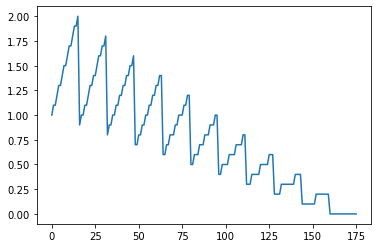

In [3]:
def get_deviation_value(ans_cor_rate, std, method="p"):
    if method == "p":
        return (1-ans_cor_rate)*(std/1.5+1)
    else:
        return (ans_cor_rate)*(std/1.5+1)

dev_vals = []
for a in np.arange(0,1.01,0.1):
    a = round(a,1)
    for s in np.arange(0, 1.501, 0.1):
        s = round(s,1)
        dev_vals.append([a, s, round(get_deviation_value(a,s),1)])

plt.plot(np.array(dev_vals)[:,2])

In [4]:
def reduce_mem_usage(df, verbose=True, y=[]):
    numerics  = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col in y or col_type not in numerics:
            continue
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if   c_min > np.iinfo(np.int8).min  and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        else:
            if   c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def showStats(df):
    stats = []
    for col in df.columns:
        stats.append((col,
                      df[col].nunique(),
                      df[col].value_counts().index[0],
                      df[col].value_counts().values[0],
                      df[col].isnull().sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      df[col].dtype))
    df_stats = pd.DataFrame(stats, columns=['Feature name', 'Unique values', 'Most frequent item', 'Freuquence of most frequent item',
                                            'Missing values(%)', 'Values in the biggest category(%)', 'Type'])
    display(df_stats)

In [5]:
# You can only call make_env() once, so don't lose it!
env = riiideducation.make_env()

In [6]:
#=========================
DEBUG     = False
TUNE      = False
ENSEMBLE  = True
S         = 0.3
L         = 0.7
#=========================

# Load data

In [7]:
%%time
train   = reduce_mem_usage(dt.fread("../input/riiid-test-answer-prediction/train.csv").to_pandas())
df_qs   = reduce_mem_usage(pd.read_csv('../input/riiid-test-answer-prediction/questions.csv'))
df_lecs = reduce_mem_usage(pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv'))

Mem. usage decreased to 3378.93 Mb (28.6% reduction)
Mem. usage decreased to  0.18 Mb (65.0% reduction)
Mem. usage decreased to  0.01 Mb (58.8% reduction)
CPU times: user 51.4 s, sys: 22.2 s, total: 1min 13s
Wall time: 1min 46s


In [8]:
print(train.shape, df_qs.shape, df_lecs.shape)
display(train.head(2))
display(df_qs.head(2))
display(df_lecs.head(2))

(101230332, 10) (13523, 5) (418, 4)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,NaN
1,1,56943,115,5716,False,2,2,1,37000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [9]:
# Modify some features
train.prior_question_elapsed_time    = (train.prior_question_elapsed_time.fillna(0)).astype(int)
train.prior_question_had_explanation = (train.prior_question_had_explanation.fillna(False) * 1).astype(int)
train.content_type_id                = (train.content_type_id * 1).astype(int)
train = reduce_mem_usage(train)

Mem. usage decreased to 2703.14 Mb (39.1% reduction)


In [10]:
# Split to qa data and lecture data
train_lec = train.query("content_type_id==1").copy()
train_lec.reset_index(drop=True, inplace=True)

train.drop(train.loc[train.content_type_id==1].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# Rename to question_id
train    .rename(columns={"content_id": "question_id"}, inplace=True)
train_lec.rename(columns={"content_id": "question_id"}, inplace=True)

gc.collect()
train.shape, train_lec.shape

((99271300, 10), (1959032, 10))

# Feature enginnering

In [11]:
def intervaled_cumsum(ar, idx):
    # Make a copy to be used as output array
    out = ar.copy()
    # Get cumumlative values of array
    arc = ar.cumsum()
    # Place differentiated values that when cumumlatively summed later on would
    # give us the desired intervaled cumsum
    out[idx[0]]    = ar[idx[0]] - arc[idx[0]-1]
    out[idx[1:-1]] = ar[idx[1:-1]] - np.diff(arc[idx[:-1]-1])
    return out.cumsum()

def shift_to_prior(ary, sizes_cumsum):
    shifted = np.r_[np.array([0]), ary]
    shifted[sizes_cumsum] = 0
    return shifted[:-1]

def get_hist_and_training_data(ary):
    return ary[sizes_qcumsum-1], ary[ext_user_bol]    

In [12]:
def cut(df, t_col, n_col):
    df = df.copy()
    df[n_col] = pd.cut(df[t_col], [-0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1], labels=False)
    df[n_col] = df[n_col].fillna(99).astype("int8")
    return df

def add_que_rate_class(df):
    df = df.copy()
    df["question_rate_class"] = 0
    for sta, end in zip(np.arange(0.3, 1.0, 0.1), np.arange(0.4, 1.1, 0.1)):
        sta = round(sta,1)
        end = round(end,1)
        end = 1.1 if end==1 else end
        df.loc[(sta <= df.question_rate)&(df.question_rate < end), "question_rate_class"] = int(sta*10)
    return df

def get_user_items_dict(ary, sizes_cumsum):
    end   = sizes_cumsum
    sta   = np.hstack([np.array([0]), end[:-1]])
    users = np.unique(ary[:,0])

    d = {}
    for u, s, e in zip(users, sta, end):
        d[u] = ary[s:e, 1:]
    return d

def change_rate_with_num(df, t_col, n_col, method="respectively", n1=5, n2=3):
    df = df.copy()
    if method == "respectively":
        df.loc[(df[n_col] < n1)&(df[t_col] <= 0.3), t_col] = 0.3
        df.loc[(df[n_col] < n1)&(0.3 < df[t_col])&(df[t_col] <= 0.7), t_col] = 0.5
        df.loc[(df[n_col] < n1)&(0.7 < df[t_col]),  t_col] = 0.7
    else:
        df.loc[(df[n_col] < n2), t_col] = 0.5
    return df

def change_rate_high_low(df, t_col, h=0.9, l=0.1):
    df = df.copy()
    df.loc[df[t_col] < l, t_col] = l
    df.loc[df[t_col] > h, t_col] = h
    return df

In [13]:
# Define some parameters for training models
CV           = 4
MODEL_NUM    = 1
USE_USER_NUM = 10000
if DEBUG:
    USE_USER_NUM  = 500
if TUNE:
    TRAIN_RATE, TUNE_RATE, TEST_RATE = 0.4, 0.3, 0.3
else:
    TRAIN_RATE, TEST_RATE = 0.7, 0.3
    
print("%s users reduce to %s" % (train.user_id.nunique(), USE_USER_NUM))
user_ids     = train.user_id.unique()
# Random shuffle
random.shuffle(user_ids)
# Get user ids for training and test
ext_user     = user_ids[:USE_USER_NUM]
ext_user_bol = np.isin(np.array(train.user_id), np.sort(ext_user))

# Get the number of user row
sizes_quser     = np.array(train.user_id.value_counts().sort_index().values, dtype="int16")
sizes_qcumsum   = sizes_quser.cumsum()
# Get unique user ids
unique_user_ids = np.array(train.user_id)[sizes_qcumsum-1]

393656 users reduce to 10000


In [14]:
# Caluculate elapsed time stats
df_etime = pd.DataFrame({"question_id"                : np.array(train.question_id[:-1]),
                         "prior_question_elapsed_time": np.array(train.prior_question_elapsed_time[1:])})
df_etime = df_etime.loc[df_etime.prior_question_elapsed_time!=0].copy()
df_etime.prior_question_elapsed_time = df_etime.prior_question_elapsed_time / (1000*3600)
df_etime["etime_kurt"] = df_etime.prior_question_elapsed_time
df_etime["etime_std"]  = df_etime.prior_question_elapsed_time
df_etime["etime_skew"] = df_etime.prior_question_elapsed_time
df_etime_kurt = df_etime.groupby("question_id", as_index=False).etime_kurt.apply(pd.DataFrame.kurt)
df_etime_rate = df_etime.groupby("question_id", as_index=False).agg({"prior_question_elapsed_time": "mean",
                                                                     "etime_std" : "std",
                                                                     "etime_skew": "skew"})
df_etime_rate.rename(columns={"prior_question_elapsed_time": "etime_mean"}, inplace=True)
df_etime_rate = df_etime_rate.merge(df_etime_kurt, on="question_id")
df_etime_rate.fillna(0, inplace=True)
df_etime_rate.question_id = df_etime_rate.question_id.astype("int32")
df_etime_rate.etime_mean  = df_etime_rate.etime_mean .astype("float32")
df_etime_rate.etime_std   = df_etime_rate.etime_std  .astype("float32")
df_etime_rate.etime_kurt  = df_etime_rate.etime_kurt .astype("float32")
df_etime_rate.etime_skew  = df_etime_rate.etime_skew .astype("float32")

# Make dictionary for prediction phase
d_etime = dict(zip(df_etime_rate.question_id, df_etime_rate.etime_mean))

del df_etime, df_etime_kurt
gc.collect()

print(df_etime_rate.shape)
df_etime_rate.head(2)

(13523, 5)


,question_id,etime_mean,etime_std,etime_skew,etime_kurt
0,0,0.005476,0.002338,18.473738,556.210571
1,1,0.005371,0.002832,16.494030,394.690826


In [15]:
# Calculate the difference between a user elapsed time and the average elapsed time
df_etmie_rate = train[["row_id","user_id","question_id","prior_question_elapsed_time"]].copy()
df_etmie_rate.rename(columns={"prior_question_elapsed_time":"lag_etime"}, inplace=True)
df_etmie_rate.lag_etime = df_etmie_rate.lag_etime / (1000*3600)
df_etmie_rate.lag_etime = df_etmie_rate.groupby("user_id").lag_etime.shift(-1)
df_etmie_rate = df_etmie_rate.merge(df_etime_rate[["question_id","etime_mean"]], on="question_id")
df_etmie_rate.lag_etime = df_etmie_rate.lag_etime - df_etmie_rate.etime_mean
df_etmie_rate.sort_values("row_id", inplace=True)
df_etmie_rate.reset_index(drop=True, inplace=True)

# Calculate elapsed time rate
df_etmie_rate["num"]        = 1
df_etmie_rate["num"]        = df_etmie_rate.groupby("user_id").num.shift(1)
df_etmie_rate["num"]        = df_etmie_rate.groupby("user_id").num.cumsum()
df_etmie_rate["num_etime"]  = df_etmie_rate.groupby("user_id").lag_etime.shift(1)
df_etmie_rate["num_etime"]  = df_etmie_rate.groupby("user_id").num_etime.cumsum()
df_etmie_rate["etime_rate"] = df_etmie_rate.num_etime / df_etmie_rate.num
df_etmie_rate.fillna(0, inplace=True)

# Save memory
df_etmie_rate.num_etime  = df_etmie_rate.num_etime .astype("float32")
df_etmie_rate.etime_rate = df_etmie_rate.etime_rate.astype("float32")
df_etmie_rate.drop(["row_id","user_id","question_id","lag_etime","etime_mean","num"], axis=1, inplace=True)

print(df_etmie_rate.shape)
display(df_etmie_rate.head(3))

# Store for history and training
ar_etmie_rate = np.array(df_etmie_rate)
hist_ar_etmie_rate, ar_etmie_rate = get_hist_and_training_data(ar_etmie_rate)
hist_ar_etmie_rate, ar_etmie_rate = hist_ar_etmie_rate[:,0], ar_etmie_rate[:,1]

del df_etmie_rate
gc.collect()

(99271300, 2)


,num_etime,etime_rate
0,0.000000,0.000000
1,0.005616,0.005616
2,0.016313,0.008156


39

In [16]:
# Run a one hot encoding for lecture features
df_lecs = df_lecs.join(pd.DataFrame(pd.get_dummies(df_lecs.type_of)))
df_lecs.rename(columns={"lecture_id"      :"question_id",
                        "solving question":"solving_question"}, inplace=True)
df_lecs.drop(["tag","type_of"], axis=1, inplace=True)
df_lecs = reduce_mem_usage(df_lecs)

# Make tag features and merge with question dataframe
tags     = sum(df_qs.tags.apply(lambda x: [] if x is np.nan else x.split(" ")), [])
df_tags  = pd.DataFrame(pd.Series(tags).value_counts(), columns=["tag"])
tags_num = df_tags.to_dict()["tag"]
df_tags.reset_index(inplace=True)
df_tags.columns  = ["tag","num"]
df_tags["total"] = df_qs.shape[0]
df_tags["tfidf"] = 1 * np.log(df_tags.total / df_tags.num)  # TF is always 1
df_tags.index = df_tags.tag
tags_tfidf    = df_tags[["tfidf"]].to_dict()["tfidf"]
df_tags = pd.DataFrame(list(df_qs.tags.apply(lambda x: [] if x is np.nan else x.split(" "))),
                       columns=["tag"+str(t) for t in range(1,7)])
df_tags = df_tags.fillna(0).astype("int16")
df_tags = df_qs[["question_id"]].join(df_tags)
df_qs["tag_rel"]       = df_qs.tags.apply(lambda x: 0 if x is np.nan else sum([tags_num[t]   for t in x.split(" ")]))
df_qs["tag_tfidf_sum"] = df_qs.tags.apply(lambda x: 0 if x is np.nan else sum([tags_tfidf[t] for t in x.split(" ")]))
#df_qs["tag_tfidf_max"] = df_qs.tags.apply(lambda x: 0 if x is np.nan else max([tags_tfidf[t] for t in x.split(" ")]))
#df_qs["tag_tfidf_min"] = df_qs.tags.apply(lambda x: 0 if x is np.nan else min([tags_tfidf[t] for t in x.split(" ")]))
df_qs["num_tag"]       = df_qs.tags.apply(lambda x: 0 if x is np.nan else len(x.split(" ")))
df_qs.drop(["correct_answer","tags"], axis=1, inplace=True)
df_qs = df_qs.merge(df_tags, on="question_id")
df_qs = reduce_mem_usage(df_qs)

del df_tags, tags_num, tags_tfidf
gc.collect()

print(df_lecs.shape, df_qs.shape)
display(df_lecs.head(2))
display(df_qs.head(2))

Mem. usage decreased to  0.00 Mb (0.0% reduction)
Mem. usage decreased to  0.39 Mb (38.8% reduction)
(418, 6) (13523, 12)


,question_id,part,concept,intention,solving_question,starter
0,89,5,1,0,0,0
1,100,1,1,0,0,0


,question_id,bundle_id,part,tag_rel,tag_tfidf_sum,num_tag,tag1,tag2,tag3,tag4,tag5,tag6
0,0,0,1,3891,12.773438,4,51,131,162,38,0,0
1,1,1,1,2654,10.921875,3,131,36,81,0,0,0


In [17]:
# Merge with question dataframe
train = train.merge(df_qs[["question_id","bundle_id","part","tag1"]], on='question_id', how='left')
train = reduce_mem_usage(train)

Mem. usage decreased to 3881.57 Mb (0.0% reduction)


In [18]:
# Calculate answering stats for each question and explanation
df_que_exp_rate = train[["question_id","prior_question_had_explanation","answered_correctly"]].copy()
df_que_exp_rate["cnt"] = 1
df_que_exp_rate = df_que_exp_rate.groupby(["question_id","prior_question_had_explanation"], as_index=False).agg({"answered_correctly":"mean", "cnt":"count"})
df_que_exp_rate.rename(columns={"answered_correctly":"question_rate"}, inplace=True)
df_que_exp_rate = change_rate_with_num(df_que_exp_rate, "question_rate", "cnt", n1=20)
df_que_exp_rate = change_rate_with_num(df_que_exp_rate, "question_rate", "cnt", method="bundle", n2=5)
df_que_exp_rate.drop("cnt", axis=1, inplace=True)
# Merge with base dataframe
df_que_exp_base = pd.DataFrame({"question_id":                    np.repeat(np.array(df_qs.question_id), 2),
                                "prior_question_had_explanation": np.tile([0,1], df_qs.shape[0])})
df_que_exp_rate = df_que_exp_base.merge(df_que_exp_rate, on=["question_id","prior_question_had_explanation"], how="left")
df_que_exp_rate.fillna(0.5, inplace=True)
df_que_exp_rate = add_que_rate_class(df_que_exp_rate)
df_que_exp_rate.question_rate       = df_que_exp_rate.question_rate.astype("float32")
df_que_exp_rate.question_rate_class = df_que_exp_rate.question_rate_class.astype("int8")
df_que_exp_rate = reduce_mem_usage(df_que_exp_rate)

print(df_que_exp_rate.shape)
df_que_exp_rate.head(2)

Mem. usage decreased to  0.36 Mb (39.1% reduction)
(27046, 4)


,question_id,prior_question_had_explanation,question_rate,question_rate_class
0,0,0,0.830566,8
1,0,1,0.912109,9


In [19]:
# Calculate answering stats for each question and bundle id
df = train[["user_id","question_id","bundle_id","user_answer","answered_correctly"]].copy()
df_question_rate = df_qs[["question_id","bundle_id"]].copy()
for c in ["question_id", "bundle_id"]:
    c_name  = c[:-3]
    df[c_name+"_kurt"] = df.user_answer
    df[c_name+"_skew"] = df.user_answer
    df_kurt = df.groupby(c, as_index=False)[c_name+"_kurt"].apply(pd.DataFrame.kurt)
    df_rate = df.groupby(c, as_index=False).agg({"answered_correctly": "mean",
                                                 "user_answer"       : "std",
                                                 c_name+"_skew"      : "skew"})
    df_rate.rename(columns={"answered_correctly":c_name+"_rate",
                            "user_answer"       :c_name+"_std"}, inplace=True)
    df_rate = df_rate.merge(df_kurt, on=c)
    df_question_rate = df_question_rate.merge(df_rate, on=c, how="left")
    df_question_rate.fillna(0, inplace=True)
    
# Rate 0 question will be replaced to second min value
min2_val = sorted(df_question_rate.question_rate.unique())[1]
ins_row  = df_question_rate[df_question_rate.question_rate == min2_val].iloc[:,2:]
df_question_rate.loc[df_question_rate.question_rate == 0, ins_row.columns] = ins_row.values

# Add deviation calculated by mean and std
df_question_rate["deviation_p"] = df_question_rate[["question_rate","question_std"]].apply(lambda x: get_deviation_value(x[0],x[1], "p"), axis=1)
df_question_rate["deviation_m"] = df_question_rate[["question_rate","question_std"]].apply(lambda x: get_deviation_value(x[0],x[1], "m"), axis=1)
# Add question rate class
df_question_rate = add_que_rate_class(df_question_rate)
df_question_rate.bundle_id           = df_question_rate.bundle_id.astype("int16")
df_question_rate.question_rate_class = df_question_rate.question_rate_class.astype("int8")
df_question_rate = reduce_mem_usage(df_question_rate)

# Calculate answering stats for each part
df_part_rate = train.groupby("part", as_index=False).answered_correctly.mean()
df_part_rate.rename(columns={"answered_correctly": "part_rate"}, inplace=True)
df_part_rate = reduce_mem_usage(df_part_rate)

del df, df_kurt, df_rate, min2_val, ins_row
gc.collect()

print(df_question_rate.shape, df_part_rate.shape)
display(df_question_rate.head(2))
display(df_part_rate.head(2))

Mem. usage decreased to  0.43 Mb (64.5% reduction)
Mem. usage decreased to  0.00 Mb (54.2% reduction)
(13523, 13) (7, 2)


,question_id,bundle_id,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_skew,bundle_kurt,deviation_p,deviation_m,question_rate_class
0,0,0,0.907715,0.510742,3.820312,14.742188,0.907715,0.510742,3.820312,14.742188,0.123718,1.216797,9
1,1,1,0.890625,0.423828,1.741211,11.640625,0.890625,0.423828,1.741211,11.640625,0.140259,1.142578,8


,part,part_rate
0,1,0.745117
1,2,0.708496


In [20]:
df_question_rate = df_question_rate.merge(df_que_exp_rate, on="question_id", suffixes=("", "_exp"))

del df_que_exp_rate
gc.collect()

20

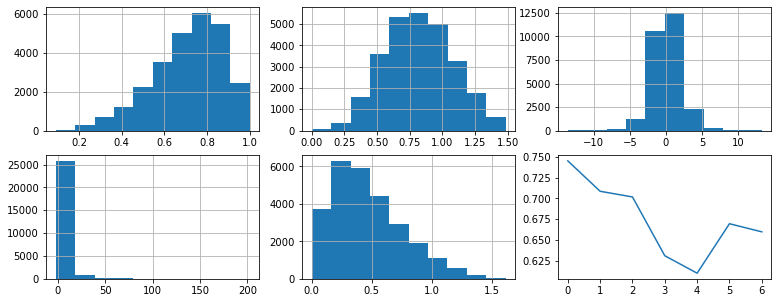

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 5))
df_question_rate.question_rate.hist(ax=axes[0,0])
df_question_rate.question_std .hist(ax=axes[0,1])
df_question_rate.question_skew.hist(ax=axes[0,2])
df_question_rate.question_kurt.hist(ax=axes[1,0])
df_question_rate.deviation_p  .hist(ax=axes[1,1])
df_part_rate.part_rate        .plot(ax=axes[1,2])

In [22]:
# Merge with DataFrame for caluculating answer rate and deviation
train = train.merge(df_question_rate[["question_id","prior_question_had_explanation","question_rate_exp","deviation_p","deviation_m"]],
                    on=["question_id","prior_question_had_explanation"])

# Sort to original order
train.sort_values(by="row_id", inplace=True)
train.reset_index(drop=True, inplace=True)

In [23]:
# Calculate correct answer rate and deviation for each user
ans  = np.array(train.answered_correctly, dtype="int16")
num  = np.ones (train.shape[0], dtype="int16")
exp  = np.array(train.prior_question_had_explanation, dtype="int16")
devp = ans  * np.array(train.deviation_p, dtype="float64")
devm = devp + np.where(ans==0, -1, 0) * np.array(train.deviation_m, dtype="float64")

ans_cumsum  = intervaled_cumsum(ans,  sizes_qcumsum).astype("int16")
num_cumsum  = intervaled_cumsum(num,  sizes_qcumsum).astype("int16")
exp_cumsum  = intervaled_cumsum(exp,  sizes_qcumsum).astype("int16")
devp_cumsum = intervaled_cumsum(devp, sizes_qcumsum).astype("float32")
devm_cumsum = intervaled_cumsum(devm, sizes_qcumsum).astype("float32")
ans_rate    = (ans_cumsum / num_cumsum).astype("float32")
study_rate  = (exp_cumsum / shift_to_prior(num_cumsum, sizes_qcumsum)).astype("float32")
study_rate[np.isnan(study_rate)] = 0
study_rate[np.isinf(study_rate)] = 0

# Store for history and training
hist_ans_cumsum,  ans_cumsum  = get_hist_and_training_data(ans_cumsum)
hist_num_cumsum,  num_cumsum  = get_hist_and_training_data(num_cumsum)
hist_exp_cumsum,  exp_cumsum  = get_hist_and_training_data(exp_cumsum)
hist_devp_cumsum, devp_cumsum = get_hist_and_training_data(devp_cumsum)
hist_devm_cumsum, devm_cumsum = get_hist_and_training_data(devm_cumsum)
hist_ans_rate,    ans_rate    = get_hist_and_training_data(ans_rate)
hist_study_rate,  _           = get_hist_and_training_data(study_rate)

train.drop(["deviation_p","deviation_m"], axis=1, inplace=True)
del ans, num, exp, devp, devm
gc.collect()

30

In [24]:
%%time
# Make column names to merge with train later
num_part_cols  = ["num_part"+str(p)     for p in range(1,8)]
ans_part_cols  = ["ans_part"+str(p)     for p in range(1,8)]
part_rate_cols = ["part"+str(p)+"_rate" for p in range(1,8)]
part_cols      = ans_part_cols + num_part_cols

# Make cumsum array for each part
ar_part_num  = np.array(pd.get_dummies(train.part))
ar_part_ans  = ar_part_num * np.array(train.answered_correctly).reshape(-1,1)
ar_part      = np.hstack([ar_part_ans, ar_part_num]).astype("int16")
del ar_part_num, ar_part_ans
gc.collect()

# Calculate correct answer rate for each part
for i in range(ar_part.shape[1]):
    ar_part[:,i] = intervaled_cumsum(ar_part[:,i], sizes_qcumsum)
ar_part_rate = (ar_part[:,:7] / ar_part[:,7:]).astype("float32")
np.nan_to_num(ar_part_rate, copy=False)

# Store for history and training
hist_ar_part_rate, _  = get_hist_and_training_data(ar_part_rate)
hist_ar_part, ar_part = get_hist_and_training_data(ar_part)

CPU times: user 32.8 s, sys: 14.4 s, total: 47.2 s
Wall time: 47.2 s


In [25]:
# Calculate answering ability for each question difficulty
abi_cols      = []
abi_rate_cols = []
for sta, end in zip([0.0] + list(np.arange(0.3, 1.0, 0.1)),
                    [0.3] + list(np.arange(0.4, 1.1, 0.1))):
    sta = round(sta,1)
    end = round(end,1)
    abi_cols      += ["ans_abi" +str(int(sta*10)), "num_abi"+str(int(sta*10))]
    abi_rate_cols += ["abi_rate"+str(int(sta*10))]
    end = 1.1 if end == 1 else end
    print("Target question rate is from %s to %s" % (sta, end))
    
    # Replace the ranged data to 0
    df_ability = train[["answered_correctly","question_rate_exp"]].copy()
    df_ability["num"] = 1
    df_ability.loc[(df_ability["question_rate_exp"] <= sta)|(end < df_ability["question_rate_exp"]), ["answered_correctly","num"]] = 0
    abians = np.array(df_ability.answered_correctly, dtype="int16")
    abinum = np.array(df_ability.num, dtype="int16")
    del df_ability
    gc. collect()
    
    # Calculate cumsum
    abians_cumsum = intervaled_cumsum(abians, sizes_qcumsum).astype("int16")
    abinum_cumsum = intervaled_cumsum(abinum, sizes_qcumsum).astype("int16")
    del abians, abinum
    gc. collect()
    
    # Store for history and training
    abians_num = np.array([abians_cumsum, abinum_cumsum]).T
    hist_abians_num, abians_num = get_hist_and_training_data(abians_num)
    if sta == 0:
        hist_ar_ability = hist_abians_num
        ar_ability      = abians_num
    else:
        hist_ar_ability = np.hstack([hist_ar_ability, hist_abians_num])
        ar_ability      = np.hstack([ar_ability,      abians_num])
    del abians_cumsum, abinum_cumsum, abians_num, hist_abians_num
    gc. collect()
    
# Sort to ans -> num order
abi_cols        = sorted(abi_cols)
abi_rate_cols   = sorted(abi_rate_cols)
hist_ar_ability = np.hstack([hist_ar_ability[:,::2], hist_ar_ability[:,1::2]])
ar_ability      = np.hstack([ar_ability[:,::2],      ar_ability[:,1::2]])

Target question rate is from 0.0 to 0.3
Target question rate is from 0.3 to 0.4
Target question rate is from 0.4 to 0.5
Target question rate is from 0.5 to 0.6
Target question rate is from 0.6 to 0.7
Target question rate is from 0.7 to 0.8
Target question rate is from 0.8 to 0.9
Target question rate is from 0.9 to 1.1


In [26]:
# Make correct answer rate classes(i.e. class 0 is based on from 0 to 0.1)
ar_class = np.hstack([unique_user_ids.reshape(-1,1),
                      hist_num_cumsum.reshape(-1,1),
                      hist_ans_rate  .reshape(-1,1),
                      hist_study_rate.reshape(-1,1),
                      hist_ar_part[:,7:],
                      hist_ar_part_rate])
df_class = pd.DataFrame(ar_class, columns=["user_id","num_que","ans_rate","study_rate"]+num_part_cols+part_rate_cols)
del ar_class, hist_ans_rate, hist_study_rate, hist_ar_part_rate
gc.collect()

# The rates that the number of answering is small will replace to Nan
df_class.loc[df_class.num_que < 5, ["ans_rate","study_rate"]] = np.nan
for p in range(1,8):
    df_class.loc[df_class["num_part"+str(p)] < 5, "part"+str(p)+"_rate"] = np.nan

# Make classes and calculate correct answer rate based on them
df_class = cut(df_class, "ans_rate",   "ans_class")
df_class = cut(df_class, "study_rate", "study_class")
for p in range(1,8):
    df_class = cut(df_class, "part"+str(p)+"_rate", "part"+str(p)+"_class")
    
# Save memory
df_class.user_id    = df_class.user_id.astype("int32")
df_class.ans_rate   = df_class.ans_rate.astype("float32")
df_class.study_rate = df_class.study_rate.astype("float32")
df_class = df_class[["user_id"] + [c for c in df_class.columns if -1 < c.find("class")]]
df_class = reduce_mem_usage(df_class)

print(df_class.shape)
df_class.head()

Mem. usage decreased to  4.88 Mb (0.0% reduction)
(393656, 10)


,user_id,ans_class,study_class,part1_class,part2_class,part3_class,part4_class,part5_class,part6_class,part7_class
0,115,6,1,7,99,99,99,99,99,99
1,124,2,0,99,99,99,2,1,99,99
2,2746,5,6,99,6,99,99,99,99,99
3,5382,6,9,6,7,99,99,6,99,99
4,8623,6,8,5,7,99,99,6,99,4


In [27]:
%%time
def make_rate_class(df, m_col):
    df_rc = df.groupby([m_col, "question_id"], as_index=False).agg(aggs)
    df_rc = df_rc.loc[df_rc[m_col] != 99].copy()
    df_rc = change_rate_with_num(df_rc, "ans_rate_class", "ans_cnt")
    df_rc.drop("ans_cnt", axis=1, inplace=True)
    return reduce_mem_usage(df_rc)

df_ans_class = train[["user_id","question_id","answered_correctly"]].merge(df_class, on="user_id")
df_ans_class["ans_cnt"] = df_ans_class.answered_correctly
df_ans_class.rename(columns={"answered_correctly": "ans_rate_class"}, inplace=True)
del df_class
gc.collect()

# Make dataframe that grouped by each class feature
# Answer rate that the number of answering is so small will be changed to 0.3/0.5/0.7
df_parts = []
aggs     = {"ans_rate_class":"mean", "ans_cnt":"count"}
df_ans_rate_class   = make_rate_class(df_ans_class, "ans_class")
df_study_rate_class = make_rate_class(df_ans_class, "study_class")
df_study_rate_class.rename(columns={"ans_rate_class":"study_rate_class"}, inplace=True)
for p in range(1,8):
    df_part_rate_class = make_rate_class(df_ans_class, f"part{p}_class")
    df_part_rate_class.rename(columns={"ans_rate_class":f"part{p}_rate_class"}, inplace=True)
    df_parts.append(df_part_rate_class)
        
# Merge with all dataframes
lo = ["base_class","question_id"]
df_ans_class = pd.DataFrame({"base_class" : np.repeat(np.arange(0,10), df_qs.question_id.nunique()),
                             "question_id": np.tile  (df_qs.question_id.unique(), 10)})
df_ans_class = df_ans_class.merge(df_ans_rate_class, left_on=lo, right_on=["ans_class", "question_id"], how="left")
df_ans_class.drop("ans_class", axis=1, inplace=True)
del df_ans_rate_class

df_ans_class = df_ans_class.merge(df_study_rate_class, left_on=lo, right_on=["study_class", "question_id"], how="left")
df_ans_class.drop("study_class", axis=1, inplace=True)
del df_study_rate_class

for p, df in enumerate(df_parts):
    df_ans_class = df_ans_class.merge(df, left_on=lo, right_on=[f"part{p+1}_class","question_id"], how="left")
    df_ans_class.drop(f"part{p+1}_class", axis=1, inplace=True)
del df_parts

# Modify
df_ans_class.fillna(0.5, inplace=True)
df_ans_class = reduce_mem_usage(df_ans_class)

gc.collect()

print(df_ans_class.shape)
df_ans_class.head()

Mem. usage decreased to  1.42 Mb (59.4% reduction)
Mem. usage decreased to  1.36 Mb (59.4% reduction)
Mem. usage decreased to  1.51 Mb (59.4% reduction)
Mem. usage decreased to  1.51 Mb (59.4% reduction)
Mem. usage decreased to  1.57 Mb (59.4% reduction)
Mem. usage decreased to  1.61 Mb (59.4% reduction)
Mem. usage decreased to  1.56 Mb (59.4% reduction)
Mem. usage decreased to  1.55 Mb (59.4% reduction)
Mem. usage decreased to  1.62 Mb (59.4% reduction)
Mem. usage decreased to  3.74 Mb (19.4% reduction)
(135230, 11)
CPU times: user 58.2 s, sys: 21 s, total: 1min 19s
Wall time: 1min 19s


,base_class,question_id,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class
0,0,0,0.500000,0.799805,0.500000,0.700195,0.799805,0.816406,0.894531,0.833496,0.899902
1,0,1,0.500000,0.700195,0.300049,0.500000,0.799805,0.759766,0.695801,0.700195,0.740723
2,0,2,0.300049,0.526367,0.000000,0.473633,0.333252,0.528320,0.449219,0.222168,0.436768
3,0,3,0.285645,0.659668,0.300049,0.600098,0.727051,0.815430,0.657227,0.799805,0.653809
4,0,4,0.000000,0.546387,0.000000,0.500000,0.562500,0.442383,0.361328,0.500000,0.444336


0

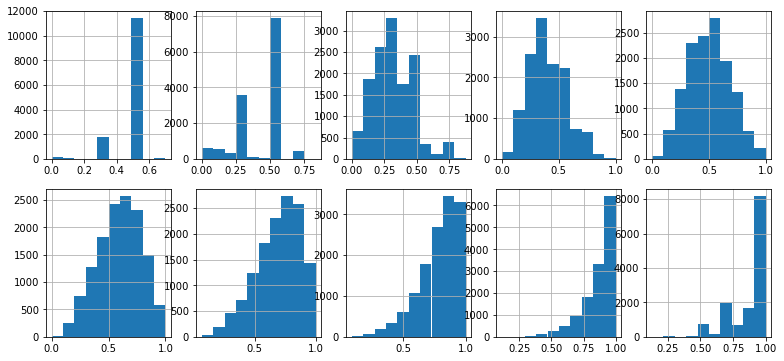

In [28]:
c = 5; r = 2; u = 0
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(13, 6))

for _r in range(r):
    for _c in range(c):
        if 9 < u: continue
        df_ans_class.loc[df_ans_class.base_class==u].ans_rate_class.hist(ax=axes[_r,_c])
        u += 1
del fig, axes
gc.collect()

26711

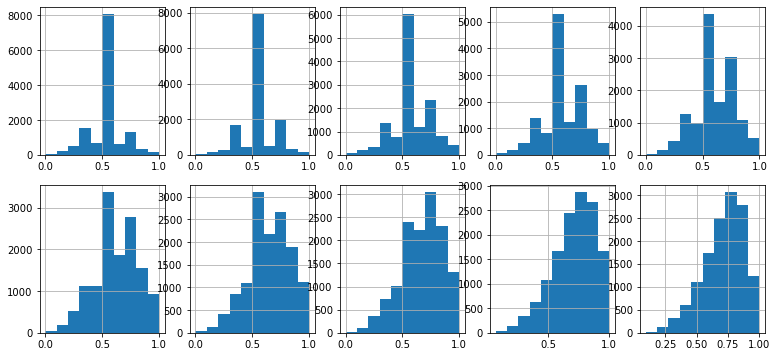

In [29]:
c = 5; r = 2; u = 0
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(13, 6))

for _r in range(r):
    for _c in range(c):
        if 9 < u: continue
        df_ans_class.loc[df_ans_class.base_class==u].study_rate_class.hist(ax=axes[_r,_c])
        u += 1
del fig, axes
gc.collect()

26726

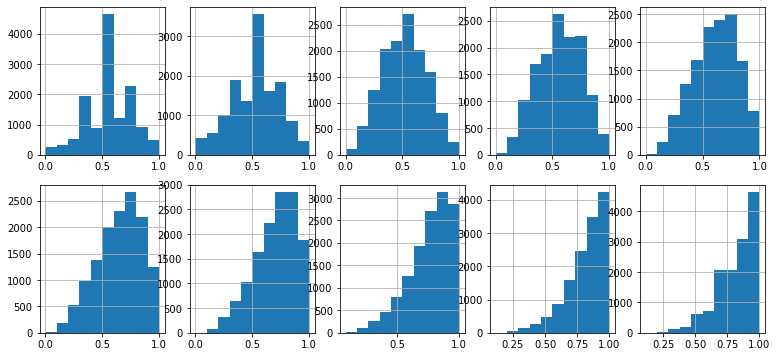

In [30]:
c = 5; r = 2; u = 0
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(13, 6))

for _r in range(r):
    for _c in range(c):
        if 9 < u: continue
        df_ans_class.loc[df_ans_class.base_class==u].part7_rate_class.hist(ax=axes[_r,_c])
        u += 1
del fig, axes
gc.collect()

In [31]:
# Saved memory concat
add_a_cols = [c for c in train_lec.columns if c not in train.columns]
add_b_cols = [c for c in train.columns if c not in train_lec.columns]
for c in add_a_cols: train[c]     = 0
for c in add_b_cols: train_lec[c] = 0
train_lec = train_lec[train.columns]
train_lec = reduce_mem_usage(train_lec)
train     = reduce_mem_usage(train)
train     = reduce_mem_usage(pd.concat([train, train_lec]))

del train_lec
gc.collect()

# Sort to original order
train.sort_values(by="row_id", inplace=True)
train.reset_index(drop=True, inplace=True)
train.shape

Mem. usage decreased to 54.18 Mb (51.7% reduction)
Mem. usage decreased to 3313.54 Mb (0.0% reduction)
Mem. usage decreased to 4151.25 Mb (0.0% reduction)


(101230332, 14)

In [32]:
# Store all timestamps for calculating the gap of continuous
sizes_all_user   = np.array(train.user_id.value_counts().sort_index().values, dtype="int16")
sizes_all_cumsum = sizes_all_user.cumsum()

t_ary       = np.array(train[["user_id","timestamp"]])
d_timestamp = get_user_items_dict(t_ary, sizes_all_cumsum)
for key, item in d_timestamp.items():
    d_timestamp[key] = np.unique(item)

del t_ary
gc.collect()

20

In [33]:
# Remove lecture rows and some columns
train.drop(["bundle_id","question_rate_exp","user_answer"], axis=1, inplace=True)
train.drop(train.loc[train.content_type_id==1].index, inplace=True)
train.drop(["content_type_id"], axis=1, inplace=True)
train.reset_index(drop=True, inplace=True)

# Make Listening(0) and Reading(1)
train["LorR"] = 0
train.loc[train.part.isin([5,6,7]), "LorR"] = 1

train = reduce_mem_usage(train)

Mem. usage decreased to 2840.17 Mb (18.9% reduction)


In [34]:
# Store latest data for prediction of real world data
ar_history = np.hstack([unique_user_ids.reshape(-1,1),
                        hist_ans_cumsum.reshape(-1,1),
                        hist_num_cumsum.reshape(-1,1),
                        hist_exp_cumsum.reshape(-1,1),
                        hist_devp_cumsum.reshape(-1,1),
                        hist_devm_cumsum.reshape(-1,1),
                        hist_ar_etmie_rate.reshape(-1,1),
                        hist_ar_part,
                        hist_ar_ability])
df_history = pd.DataFrame(ar_history, columns=["user_id","num_ans","num_que","num_exp","num_devp","num_devm","num_etime"]+part_cols+abi_cols)
for c in df_history.columns:
    if c not in ["num_devp","num_devm","num_etime"]:
        df_history[c] = df_history[c].astype(int)
df_history = reduce_mem_usage(df_history)
df_history.sort_values(by="user_id", inplace=True)
df_history.reset_index(drop=True, inplace=True)

del hist_ans_cumsum, hist_num_cumsum, hist_exp_cumsum, hist_devp_cumsum, hist_devm_cumsum, hist_ar_etmie_rate, hist_ar_part, hist_ar_ability
gc.collect()

print(df_history.shape)
df_history.head()

Mem. usage decreased to 28.53 Mb (74.3% reduction)
(393656, 37)


,user_id,num_ans,num_que,num_exp,num_devp,num_devm,num_etime,ans_part1,ans_part2,ans_part3,ans_part4,ans_part5,ans_part6,ans_part7,num_part1,num_part2,num_part3,num_part4,num_part5,num_part6,num_part7,ans_abi0,ans_abi3,ans_abi4,ans_abi5,ans_abi6,ans_abi7,ans_abi8,ans_abi9,num_abi0,num_abi3,num_abi4,num_abi5,num_abi6,num_abi7,num_abi8,num_abi9
0,115,32,46,6,11.531250,-0.943359,-0.012329,26,1,2,1,2,0,0,37,1,3,3,2,0,0,0,3,2,2,3,6,5,11,4,4,2,4,6,6,9,11
1,124,7,30,0,6.316406,-10.265625,-0.043335,2,0,1,2,1,1,0,3,1,3,9,6,4,4,2,1,1,0,2,0,1,0,11,3,6,4,4,0,2,0
2,2746,11,19,11,4.601562,-4.851562,-0.001500,0,11,0,0,0,0,0,0,17,0,0,2,0,0,0,0,1,1,1,4,4,0,1,0,1,3,4,4,6,0
3,5382,84,125,113,43.656250,4.175781,0.455811,8,25,0,0,51,0,0,13,32,0,0,80,0,0,1,2,4,12,27,27,9,2,3,4,12,21,35,37,10,3
4,8623,70,109,96,42.625000,9.820312,-0.029327,11,31,0,0,21,0,7,19,44,0,0,31,0,15,4,4,10,10,14,16,9,3,9,11,17,18,22,20,9,3


In [35]:
print(train.shape)
train.head()

(99271300, 11)


,row_id,timestamp,user_id,question_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,tag1,LorR
0,0,0,115,5692,1,1,0,0,5,151,1
1,1,56943,115,5716,2,1,37000,0,5,168,1
2,2,118363,115,128,0,1,55000,0,1,131,0
3,3,131167,115,7860,3,1,19000,0,1,131,0
4,4,137965,115,7922,4,1,11000,0,1,131,0


# Make training data

In [36]:
def get_attempt_que(u, r, q):
    # u: user_id
    # r: row_id
    # q: question_id
    if u in d.keys():
        ua = d[u]
        return np.count_nonzero((ua[:,0] < r) * (ua[:,1] == q))
    return 0

def get_attempt_curt_part(u, r, p):
    # u: user_id
    # r: row_id
    # p: part
    if u in d.keys():
        ua = d[u]
        return np.count_nonzero(ua[ua[:,0]<r][-5:,2] == p)
    return 0

def get_attempt_tags(u, r, t):
    # u: user_id
    # r: row_id
    # t: tags
    if u in d.keys():
        ua = d[u]
        return np.count_nonzero((ua[:,0] < r) * (ua[:,3] == t))
    return 0

def get_attempt_curt_ans_rate(u, r):
    # u : user_id
    # r : row_id
    if u in d.keys():
        ua = d[u]
        return np.mean(ua[ua[:,0]<r][-10:, 4])
    return 0

def get_lagtime(u, t, l):
    # u: user_id
    # t: timestamp
    # l: lag(-1 is lag1, -2 is lag2, -3 is lag3)
    if u in d_timestamp.keys():
        ul = d_timestamp[u]
        ul = ul[ul < t]
        if   ul.shape[0] >= 3:
            return ul[l]
        elif ul.shape[0] == 2 and l != -3:
            return ul[l]
        elif ul.shape[0] == 1 and l == -1:
            return ul[l]
    return 0

def get_noplay_days(u, t):
    # u: user_id
    # t: normalized timestamp
    if u in d_timestamp.keys():
        ul = d_timestamp[u] / (1000*3600)
        ul = ul[ul <= t]
        if 1 < ul.shape[0]:
            di = np.diff(ul)
            return np.where(di<24,0,di).sum()
    return 0

def get_attempt_thedaybefore(u, t, d):
    # u: user_id
    # t: normalized timestamp
    # d: days(7 is 1 week ago, 1 is 24 hours ago, 0.5 is 12 hours ago)
    if u in d_timestamp.keys():
        ul = d_timestamp[u] / (1000*3600)
        return np.count_nonzero((t-d <= ul) * (ul < t))
    return 0

def cut_and_merge_with_class(df, df_class, t_col, c_col):
    df = df.copy()
    df["base_class"] = pd.cut(df[t_col], [-0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1], labels=False)
    return df.merge(df_class[["question_id","base_class",c_col]], on=["question_id","base_class"], sort=False)

In [37]:
data  = train[train.user_id.isin(ext_user)].copy()
data.reset_index(drop=True, inplace=True)

# Store all user id for calculating attempt
q_ary = np.array(train[["user_id","row_id","question_id","part","tag1","answered_correctly"]])
q_ary = q_ary[np.argsort(q_ary[:,1])]
del train
gc.collect()

train = data.copy()
sizes_train_user   = np.array(train.user_id.value_counts().sort_index().values, dtype="int16")
sizes_train_cumsum = sizes_train_user.cumsum()
del data
gc.collect()

train.shape

(2605074, 11)

In [38]:
%%time
# CV strategy
def rand_time(max_time_stamp):
    interval = MAX_TIME_STAMP - max_time_stamp
    rand_time_stamp = random.randint(0,interval)
    return rand_time_stamp

max_timestamp_u = train[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
MAX_TIME_STAMP  = max_timestamp_u.max_time_stamp.max()

max_timestamp_u['rand_time_stamp'] = max_timestamp_u.max_time_stamp.apply(lambda x: rand_time(x))
train = train.merge(max_timestamp_u, on='user_id')
train['viretual_time_stamp'] = train.timestamp + train['rand_time_stamp']
train.sort_values(['viretual_time_stamp', 'row_id'], inplace=True)
train.reset_index(drop=True, inplace=True)

train_num = int(train.shape[0] * TRAIN_RATE)
if TUNE:
    tune_num = int(train.shape[0] * TUNE_RATE)
    test_num = train.shape[0] - (train_num + tune_num)
else:
    test_num = train.shape[0] - train_num
    tune_num = 0
print(train_num, test_num, tune_num)

# Add CV group
train["cv_group"] = 9
sta = 0
for c in range(CV):
    end = int(train_num/CV)*(c+1) if (c+1) != CV else train_num
    train.loc[sta:end, "cv_group"] = c
    print("CV:%s -- Start with %07d and end with %07d. Num of user is %s and mean correct answer rate is %f" % (c, sta, end, train.loc[train.cv_group==c].user_id.nunique(), train.loc[train.cv_group==c].answered_correctly.mean()))
    sta = end
if TUNE:
    train.loc[train_num+1:train_num+tune_num, "cv_group"] = 5
    train.loc[train_num+tune_num+1:,          "cv_group"] = 4
else:
    train.loc[train_num+1:train_num+test_num, "cv_group"] = 4

train.sort_values('row_id', inplace=True)
train.reset_index(drop=True, inplace=True)

1823551 781523 0
CV:0 -- Start with 0000000 and end with 0455887. Num of user is 2407 and mean correct answer rate is 0.652752
CV:1 -- Start with 0455887 and end with 0911774. Num of user is 2234 and mean correct answer rate is 0.655696
CV:2 -- Start with 0911774 and end with 1367661. Num of user is 2167 and mean correct answer rate is 0.667072
CV:3 -- Start with 1367661 and end with 1823551. Num of user is 2141 and mean correct answer rate is 0.667418
CPU times: user 3.61 s, sys: 440 ms, total: 4.05 s
Wall time: 4.05 s


In [39]:
# Add correct answer rate after shifting to prior
devp_rate = (devp_cumsum / num_cumsum).astype("float32")
devm_rate = (devm_cumsum / num_cumsum).astype("float32")
train["ans_rate"]   = shift_to_prior(ans_rate,   sizes_train_cumsum).astype("float32")
train["devp_rate"]  = shift_to_prior(devp_rate,  sizes_train_cumsum).astype("float32")
train["devm_rate"]  = shift_to_prior(devm_rate,  sizes_train_cumsum).astype("float32")
train["num_que"]    = shift_to_prior(num_cumsum, sizes_train_cumsum).astype("int16")
train["num_exp"]    = exp_cumsum.astype("int16")
train["study_rate"] = (train.num_exp / train.num_que).replace([np.inf,-np.inf], np.nan).fillna(0).astype("float32")

train = reduce_mem_usage(train)

del ans_rate, devp_rate, devm_rate, num_cumsum, exp_cumsum
gc.collect()

Mem. usage decreased to 166.45 Mb (18.3% reduction)


46

In [40]:
# Calculate correct answer rate for each part
ar_part_rate = ar_part[:,:7] / ar_part[:,7:]
np.nan_to_num(ar_part_rate, copy=False)
ar_part_rate = ar_part_rate.astype("float32")

# Shift to prior
for i in range(ar_part_rate.shape[1]):
    ar_part_rate[:,i] = shift_to_prior(ar_part_rate[:,i], sizes_train_cumsum)
for i in range(ar_part.shape[1]):
    ar_part[:,i]      = shift_to_prior(ar_part[:,i],      sizes_train_cumsum)

ar_part_rate.shape, ar_part.shape

((2605074, 7), (2605074, 14))

In [41]:
# Calculate answering ability for each question difficulty
ar_ability_rate = ar_ability[:,:8] / ar_ability[:,8:]
np.nan_to_num(ar_ability_rate, copy=False)
ar_ability_rate = ar_ability_rate.astype("float32")

# Shift to prior
for i in range(ar_ability_rate.shape[1]):
    ar_ability_rate[:,i] = shift_to_prior(ar_ability_rate[:,i], sizes_train_cumsum)

ar_ability_rate.shape

(2605074, 8)

In [42]:
train = train.join(pd.DataFrame(ar_part_rate,    columns=part_rate_cols))
train = train.join(pd.DataFrame(ar_part[:,7:],   columns=num_part_cols))
train = train.join(pd.DataFrame(ar_ability_rate, columns=abi_rate_cols))
train = train.join(pd.DataFrame(ar_etmie_rate,   columns=["etime_rate"]))

train.sort_values("row_id", inplace=True)
train.reset_index(drop=True, inplace=True)

del ar_part_rate, ar_part, ar_ability_rate
gc.collect()
train.shape

(2605074, 44)

In [43]:
%%time
print("Calculating the gap of continuous")
train["lagtime1"]  = (train[["user_id","timestamp"]].parallel_apply(lambda x: get_lagtime(x[0], x[1], -1), axis=1) / (1000*3600)).astype("float32")
train["lagtime2"]  = (train[["user_id","timestamp"]].parallel_apply(lambda x: get_lagtime(x[0], x[1], -2), axis=1) / (1000*3600)).astype("float32")
train["lagtime3"]  = (train[["user_id","timestamp"]].parallel_apply(lambda x: get_lagtime(x[0], x[1], -3), axis=1) / (1000*3600)).astype("float32")
train["timestamp"] = (train.timestamp / (1000*3600)).astype("float32")
train["lagtime1"]  = (train.timestamp - train.lagtime1).astype("float32")
train["lagtime2"]  = (train.timestamp - train.lagtime2).astype("float32")
train["lagtime3"]  = (train.timestamp - train.lagtime3).astype("float32")

#print("Calculating the number of attempt within 12 hours/24 hours/1 week")
#train["attempt_12hours"] = train[["user_id","timestamp"]].apply(lambda x: get_attempt_thedaybefore(x[0], x[1], 0.5), axis=1)
#train["attempt_24hours"] = train[["user_id","timestamp"]].apply(lambda x: get_attempt_thedaybefore(x[0], x[1], 1),   axis=1)
#train["attempt_1week"]   = train[["user_id","timestamp"]].apply(lambda x: get_attempt_thedaybefore(x[0], x[1], 7),   axis=1)

print("Calculating total of no play days")
train["noplay_days"]    = (train[["user_id","timestamp"]].parallel_apply(lambda x: get_noplay_days(x[0], x[1]), axis=1)).astype("float32")

# Add elapsed days
train["elapsed_days"]   = (train.timestamp / 24).astype("int32")

# Add rate of timestamp
train["noplay_rate"]    = (train.noplay_days  / train.num_que).fillna(0).astype("float32")
train["timestamp_rate"] = (train.timestamp    / train.num_que).fillna(0).astype("float32")
train["elapsed_rate"]   = (train.elapsed_days / train.num_que).fillna(0).astype("float32")

Calculating the gap of continuous
Calculating total of no play days
CPU times: user 733 ms, sys: 1.19 s, total: 1.92 s
Wall time: 2min 42s


In [44]:
%%time
d = get_user_items_dict(q_ary, sizes_qcumsum)
    
print("Calculating the number of attempt against the same question")
train["attempt_que"]    = train[["user_id","row_id","question_id"]].parallel_apply(lambda x: get_attempt_que(x[0], x[1], x[2]), axis=1)

tags_cols = ["tag"+str(t) for t in range(1,7)]
print("Calculating the number of attempt against the same tag")
train["attempt_tags"]   = train[["user_id","row_id","tag1"]].parallel_apply(lambda x: get_attempt_tags(x[0], x[1], x[2]), axis=1)

print("Calculating the current correct answer rate")
train["attempt_curtar"] = train[["user_id","row_id"]].parallel_apply(lambda x: get_attempt_curt_ans_rate(x[0], x[1]), axis=1)

#print("Calculating the number of attempt against the same part")
#train["attempt_curtp"]  = train[["user_id","row_id","part"]].apply(lambda x: get_attempt_curt_part(x[0], x[1], x[2]), axis=1)

#print("Calculating the number of attempt against the same question format")
#train["attempt_curtLR"] = train[["user_id","row_id","LorR"]].apply(lambda x: get_attempt_curt_LR(x[0], x[1], x[2]), axis=1)

Calculating the number of attempt against the same question
Calculating the number of attempt against the same tag
Calculating the current correct answer rate
CPU times: user 3.14 s, sys: 1.02 s, total: 4.16 s
Wall time: 2min 53s


In [45]:
%%time
train = cut_and_merge_with_class(train, df_ans_class, "ans_rate",   "ans_rate_class")
train = cut_and_merge_with_class(train, df_ans_class, "study_rate", "study_rate_class")
for p in range(1,8):
    train = cut_and_merge_with_class(train, df_ans_class, f"part{p}_rate", f"part{p}_rate_class")
train.drop("base_class", axis=1, inplace=True)
train.shape

CPU times: user 12.1 s, sys: 1.17 s, total: 13.3 s
Wall time: 13.3 s


(2604912, 64)

In [46]:
train = train.merge(df_qs.drop(["part","tag1"], axis=1), on="question_id")
train = train.merge(df_question_rate, on=["question_id","bundle_id","prior_question_had_explanation"])
train = train.merge(df_etime_rate,    on="question_id")
train = train.merge(df_part_rate,     on="part")

gc.collect()

32

In [47]:
t_cols = ["ans_rate_class","study_rate_class"] + ["part"+str(p)+"_rate_class" for p in range(1,8)]
n_cols = ["num_que",       "num_que"]          + num_part_cols
for t, n in zip(t_cols, n_cols):
    train = change_rate_with_num(train, t, n, method="respectively")
    train = change_rate_with_num(train, t, n, method="bundle")

In [48]:
# Make chance of making a mistake features
train["prob_mistake_que"] = train.num_que.apply(lambda x: 0.6*x**(-0.2) if x!=0 else 0.6)
part_mistake_cols = []
for p in range(1,8):
    part_mistake_cols.append("prob_mistake_part"+str(p))
    train["prob_mistake_part"+str(p)] = train["num_part"+str(p)].apply(lambda x: 0.6*x**(-0.2) if x!=0 else 0.6)
all_prob_mistake = np.array(train[part_mistake_cols])
train["prob_mistake_part_curt"] = np.nanmax(np.identity(8) [train.part][:,1:]*all_prob_mistake, axis=1)
    
# Make current part/part rate/ability features
all_part_rate  = np.array(train[["part1_rate","part2_rate","part3_rate","part4_rate","part5_rate","part6_rate","part7_rate"]])
all_part_ratec = np.array(train[["part1_rate_class","part2_rate_class","part3_rate_class","part4_rate_class","part5_rate_class","part6_rate_class","part7_rate_class"]])
all_abi_rate   = np.array(train[["abi_rate0","abi_rate3","abi_rate4","abi_rate5","abi_rate6","abi_rate7","abi_rate8","abi_rate9"]])
train["part_rate_curt"]  = np.nanmax(np.identity(8) [train.part][:,1:]*all_part_rate, axis=1)
train["part_ratec_curt"] = np.nanmax(np.identity(8) [train.part][:,1:]*all_part_ratec, axis=1)
train["abi_rate_curt"]   = np.nanmax(np.identity(10)[train.question_rate_class_exp][:,[0,3,4,5,6,7,8,9]]*all_abi_rate, axis=1)
train["part_ratec_mean"] = np.nan_to_num(all_part_ratec).sum(1) / 7

del all_part_rate, all_part_ratec, all_abi_rate
gc.collect()

# Make harmonic features
# Comparison between:
#  - a correct answer rate against all questions and a correct answer rate against the part
#  - a correct answer rate of someone who looks like you and a correct answer rate of the question
#  - a correct answer rate of someone who looks like you and a correct answer rate against the part
#  - a correct answer rate against the part and a correct answer rate of the part
#  - a correct answer rate of someone who looks like you and a correct answer rate of the question
#  - a correct answer rate of the part and a correct answer rate of the question
#  - a correct answer rate against questions difficulty and a correct answer rate of the question
train["harmonic_ar_prc"]   = 2 * (train.ans_rate         * train.part_rate_curt)    / (train.ans_rate         + train.part_rate_curt)
train["harmonic_arc_qr"]   = 2 * (train.ans_rate_class   * train.question_rate_exp) / (train.ans_rate_class   + train.question_rate_exp)
train["harmonic_arc_prcc"] = 2 * (train.ans_rate_class   * train.part_ratec_curt)   / (train.ans_rate_class   + train.part_ratec_curt)
train["harmonic_prc_pr"]   = 2 * (train.part_rate_curt   * train.part_rate)         / (train.part_rate_curt   + train.part_rate)
train["harmonic_prcc_qr"]  = 2 * (train.part_ratec_curt  * train.question_rate_exp) / (train.part_ratec_curt  + train.question_rate_exp)
train["harmonic_qr_pr"]    = 2 * (train.part_rate        * train.question_rate_exp) / (train.part_rate        + train.question_rate_exp)
train["harmonic_abrc_qr"]  = 2 * (train.abi_rate_curt    * train.question_rate_exp) / (train.abi_rate_curt    + train.question_rate_exp)
train["harmonic_arc_src"]  = 2 * (train.ans_rate_class   * train.study_rate_class)  / (train.ans_rate_class   + train.study_rate_class)
train["harmonic_prcc_src"] = 2 * (train.part_ratec_curt  * train.study_rate_class)  / (train.part_ratec_curt  + train.study_rate_class)
train["harmonic_src_qr"]   = 2 * (train.study_rate_class * train.question_rate_exp) / (train.study_rate_class + train.question_rate_exp)

# Make rate features
train["rate_arc_prcc"]   = train.ans_rate_class  / train.part_ratec_curt
train["rate_arc_src"]    = train.ans_rate_class  / train.study_rate_class
train["rate_prcc_src"]   = train.part_ratec_curt / train.study_rate_class
train["rate_arc_qr"]     = train.ans_rate_class  / train.question_rate_exp
train["rate_qr_pr"]      = train.part_rate       / train.question_rate_exp
train["rate_prcc_prccm"] = train.part_ratec_curt / train.part_ratec_mean

In [49]:
train.fillna(0, inplace=True)
train.sort_values(by="row_id", inplace=True)
train.reset_index(drop=True, inplace=True)

198

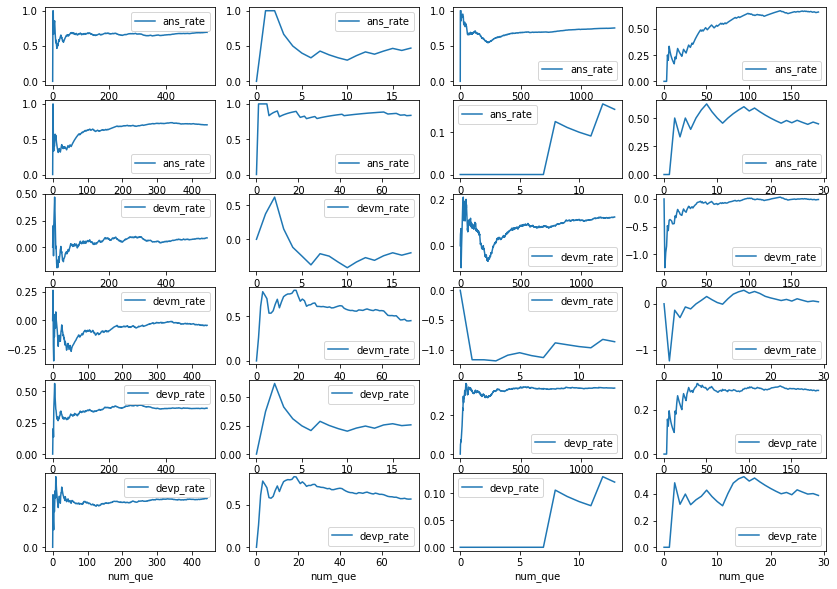

In [50]:
def plot(rs, re, c, t_col):
    u = 0
    for _r in range(rs, re):
        for _c in range(c):
            train.loc[train.user_id==ids[u]].plot(x="num_que", y=t_col, ax=axes[_r,_c])
            u += 1
c = 4; r = 2
ids = train.user_id.unique()
random.shuffle(ids)
fig, axes = plt.subplots(nrows=r*3, ncols=c, figsize=(14, 10))

plot(0,   r,   c, "ans_rate")
plot(r,   r*2, c, "devm_rate")
plot(r*2, r*3, c, "devp_rate")

del ids, fig, axes
gc.collect()

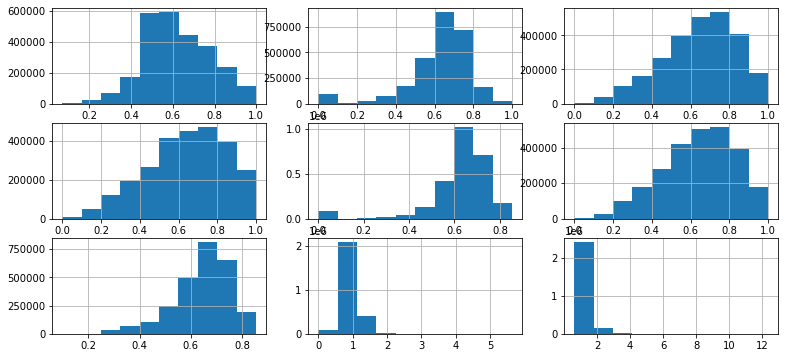

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 6))
train.part_ratec_mean  .hist(ax=axes[0,0])
train.harmonic_ar_prc  .hist(ax=axes[0,1])
train.harmonic_arc_qr  .hist(ax=axes[0,2])
train.harmonic_arc_prcc.hist(ax=axes[1,0])
train.harmonic_prc_pr  .hist(ax=axes[1,1])
train.harmonic_prcc_qr .hist(ax=axes[1,2])
train.harmonic_qr_pr   .hist(ax=axes[2,0])
train.rate_arc_qr      .hist(ax=axes[2,1])
train.rate_qr_pr       .hist(ax=axes[2,2])

In [52]:
print(train.shape)
train.head()

(2604912, 120)


,row_id,timestamp,user_id,question_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,tag1,LorR,max_time_stamp,rand_time_stamp,viretual_time_stamp,cv_group,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,num_part1,num_part2,num_part3,num_part4,num_part5,num_part6,num_part7,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,bundle_id,tag_rel,tag_tfidf_sum,num_tag,tag2,tag3,tag4,tag5,tag6,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_skew,bundle_kurt,deviation_p,deviation_m,question_rate_class,question_rate_exp,question_rate_class_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part1,prob_mistake_part2,prob_mistake_part3,prob_mistake_part4,prob_mistake_part5,prob_mistake_part6,prob_mistake_part7,prob_mistake_part_curt,part_rate_curt,part_ratec_curt,abi_rate_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
0,21484,0.000000,355138,7900,0,1,0,0,1,131,0,918876,24474765911,24474765911,1,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.000000,0.0,0,0,0.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,7900,2677,10.414062,3,93,81,0,0,0,0.826172,0.762207,2.158203,3.316406,0.826172,0.762207,2.158203,3.316406,0.262207,1.246094,8,0.823730,8,0.006270,0.003142,10.677766,204.742294,0.745117,0.600000,0.600000,0.6,0.6,0.6,0.6,0.6,0.6,0.60000,0.0,0.5,0.0,0.5,0.0,0.622070,0.500000,0.000000,0.622280,0.782715,0.000000,0.500000,0.5,0.622070,1.000000,1.000000,1.0,0.606934,0.904785,1.0
1,21485,0.006824,355138,7876,1,1,30000,0,1,10,0,918876,24474765911,24474790476,1,1.000000,0.262207,0.262207,1,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.002063,0.006824,0.006824,0.006824,0.0,0,0.0,0.006824,0.0,0,0,1.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,7876,2589,11.835938,3,94,92,0,0,0,0.418457,0.991211,-0.963379,-0.101257,0.418457,0.991211,-0.963379,-0.101257,0.965820,0.694824,4,0.393555,3,0.006355,0.002361,14.212908,384.552673,0.745117,0.600000,0.600000,0.6,0.6,0.6,0.6,0.6,0.6,0.60000,1.0,0.5,0.0,0.5,1.0,0.440430,0.500000,0.853945,0.440437,0.515137,0.000000,0.500000,0.5,0.440430,1.000000,1.000000,1.0,1.270508,1.893555,1.0
2,21486,0.013935,355138,175,2,0,22000,0,1,9,0,918876,24474765911,24474816077,1,1.000000,0.614258,0.614258,2,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000909,0.007111,0.013935,0.013935,0.0,0,0.0,0.006967,0.0,0,0,1.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,175,2686,10.312500,3,10,92,0,0,0,0.359863,1.100586,-0.092712,-1.349609,0.359863,1.100586,-0.092712,-1.349609,1.109375,0.624023,3,0.344482,3,0.006694,0.002540,12.950506,323.384888,0.745117,0.522330,0.522330,0.6,0.6,0.6,0.6,0.6,0.6,0.52233,1.0,0.5,1.0,0.5,1.0,0.407715,0.500000,0.853945,0.407921,0.470947,0.512439,0.500000,0.5,0.407715,1.000000,1.000000,1.0,1.451172,2.162109,1.0
3,21487,0.020577,355138,1278,3,1,23000,0,2,143,0,918876,24474765911,24474839989,1,0.666504,0.409424,0.201294,3,0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,0,0,0,0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.000504,0.006642,0.013754,0.020577,0.0,0,0.0,0.006859,0.0,0,0,0.666667,0.700195,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1278,4500,11.734375,4,140,81,29,0,0,0.649414,1.186523,-0.817383,-1.0

In [53]:
#showStats(train.drop(["row_id","user_id"], axis=1))

# LGBM training 

In [54]:
class BaseModel(object):
    """
    Base Model Class:

    train_df         : train pandas dataframe
    test_df          : test pandas dataframe
    target           : target column name (str)
    features         : list of feature names
    categoricals     : list of categorical feature names
    n_splits         : K in KFold (default is 3)
    cv_method        : options are .. KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold, or GroupShuffleSplit
    group            : group feature name when GroupKFold or StratifiedGroupKFold are used
    task             : options are .. regression, multiclass, or binary
    param            : dict of parameter, set that if you already define
    parameter_tuning : bool, only for LGB
    seed             : seed (int)
    verbose          : bool
    """

    def __init__(self, train_df, test_df, target, features, 
                 valid_df=None, tune_df=None, categoricals=[], alpha=0, 
                 n_splits=3, cv_method="KFold", group=None,
                 task="regression", params=None, parameter_tuning=False,
                 tuning_type="optuna_tuner", seed=42, verbose=True):
        self.train_df     = train_df
        self.test_df      = test_df
        self.valid_df     = valid_df
        self.tune_df      = tune_df
        self.target       = target
        self.features     = features
        self.n_splits     = n_splits
        self.categoricals = categoricals
        self.alpha        = alpha
        self.cv_method    = cv_method
        self.group        = group
        self.task         = task
        self.parameter_tuning = parameter_tuning
        self.seed    = seed
        self.cv      = self.get_cv()
        self.verbose = verbose
        self.tuning_type = tuning_type
        if params is None:
            self.params  = self.get_params()
        else:
            self.params  = params
        self.y_pred, self.y_valid, self.score, self.models, self.oof, self.y_val, self.fi_df = self.fit()

    def train_model(self, train_set, val_set):
        raise NotImplementedError

    def get_params(self):
        raise NotImplementedError

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError

    def calc_metric(self, y_true, y_pred): # this may need to be changed based on the metric of interest
        if   self.task in ("multiclass","nn_multiclass"):
            preds = np.argmax(y_pred, axis=1) if y_true.shape != y_pred.shape else y_pred
            return f1_score(y_true, preds, average='macro')                
        elif self.task == "binary":
            return roc_auc_score(y_true, y_pred, average='macro')
        elif self.task in ("regression","quantile"):
            return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def get_cv(self):
        if self.cv_method == "KFold":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df)
        if self.cv_method == "StratifiedKFold":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target])
        if self.cv_method == "TimeSeriesSplit":
            cv = TimeSeriesSplit(max_train_size=None, n_splits=self.n_splits)
            return cv.split(self.train_df)
        if self.cv_method == "GroupKFold":
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df[self.features+self.categoricals], self.train_df[self.target], self.train_df[self.group])
        if self.cv_method == "GroupShuffleSplit":
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
            cv = GroupShuffleSplit(n_splits=self.n_splits, random_state=self.seed)
            return cv.split(self.train_df[self.features+self.categoricals], self.train_df[self.target], self.train_df[self.group])

    def fit(self):
        # Initialize
        y_vals = np.zeros((self.train_df.shape[0], ))
        if self.task in ("multiclass","nn_multiclass"):
            col_len = self.train_df[self.target].nunique()
        else:
            col_len = 1
        oof_pred = np.zeros((self.train_df.shape[0], col_len))
        y_pred   = np.zeros((self.test_df.shape[0],  col_len))
        y_valid  = np.zeros((self.valid_df.shape[0], col_len)) if self.valid_df is not None else None
        models   = []
        
        if self.group is not None:
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
                
        fi = np.zeros((self.n_splits, len(self.features+self.categoricals)))
        if y_valid is not None:
            x_valid = self.valid_df[self.features+self.categoricals].copy()
            del self.valid_df
            gc.collect()
        x_test = self.test_df[self.features+self.categoricals]

        # Fitting with out of fold
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # Prepare train and test dataset
            x_train = self.train_df.iloc[train_idx, :][self.features+self.categoricals]
            y_train = self.train_df.iloc[train_idx, :][self.target]
            x_val   = self.train_df.iloc[val_idx, :][self.features+self.categoricals]
            y_val   = self.train_df.iloc[val_idx, :][self.target]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            del x_train, y_train
            gc.collect()
            
            # Fit model
            model, importance = self.train_model(train_set, val_set)
            fi[fold, :]       = importance
            y_vals[val_idx]   = y_val
            
            # Get some scores
            oof_pred[val_idx] = model.predict(x_val, num_iteration=model.best_iteration).reshape(oof_pred[val_idx].shape)
            if y_valid is not None:
                y_valid += model.predict(x_valid, num_iteration=model.best_iteration).reshape(y_valid.shape) / self.n_splits
            y_pred += model.predict(x_test, num_iteration=model.best_iteration).reshape(y_pred.shape) / self.n_splits
            
            print('Partial score of fold {} is: {}'.format(fold, self.calc_metric(y_val, oof_pred[val_idx])))
            models.append(model)
            
            del train_set, val_set, x_val, y_val
            gc.collect()
        
        # Create feature importance data frame
        fi_df = pd.DataFrame()
        for n in np.arange(self.n_splits):
            tmp = pd.DataFrame()
            tmp["features"]   = self.features+self.categoricals
            tmp["importance"] = fi[n, :]
            tmp["fold"]       = n
            fi_df = pd.concat([fi_df, tmp], ignore_index=True)
        gfi   = fi_df[["features", "importance"]].groupby(["features"]).mean().reset_index()
        fi_df = fi_df.merge(gfi, on="features", how="left", suffixes=('', '_mean'))
        
        # Calculate oof score
        loss_score = self.calc_metric(y_vals, oof_pred)
        print('Our oof loss score is: ', loss_score)
        
        return y_pred, y_valid, loss_score, models, oof_pred, y_vals, fi_df

    def plot_feature_importance(self, rank_range=[1, 100]):
        fig, ax   = plt.subplots(1, 1, figsize=(16, 12))
        sorted_df = self.fi_df.sort_values(by="importance_mean", ascending=False).reset_index()
        sns.barplot(data=sorted_df.iloc[self.n_splits*(rank_range[0]-1) : self.n_splits*rank_range[1]],
                    x="importance", y="features", orient='h')
        ax.set_xlabel("feature importance")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        return sorted_df
    
class LgbModel(BaseModel):
    """
    LGB wrapper
    """
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = lgb.train(self.params, train_set, num_boost_round=3000,
                          valid_sets=[train_set, val_set], verbose_eval=verbosity)
        fi = model.feature_importance(importance_type="gain")
        return model, fi

    def convert_dataset(self, x_train, y_train, x_val=None, y_val=None):
        train_set   = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        if x_val is not None:
            val_set = lgb.Dataset(x_val,   y_val,   categorical_feature=self.categoricals)
            return train_set, val_set
        return train_set

    def get_params(self):
        # Fast fit parameters
        params = {
            'boosting_type'    : "gbdt",
            'objective'        : self.task,
            "subsample"        : 0.4,
            "subsample_freq"   : 1,
            'max_depth'        : 4,
            'min_data_in_leaf' : 50,
            'learning_rate'    : 0.05,
            'early_stopping_rounds' : 100,
            'bagging_seed'     : 11,
            'random_state'     : 42,
            'verbosity'        : -1
        }

        # List is here: https://lightgbm.readthedocs.io/en/latest/Parameters.html
        if   self.task == "regression":
            params["metric"]    = "regression_l2"
        elif self.task == "quantile":
            params["metric"]    = "quantile"
            params["alpha"]     = self.alpha
        elif self.task == "binary":
            params["metric"]    = "auc"  # binary_logloss
        elif self.task == "multiclass":
            params["metric"]    = "multi_logloss"
            params["num_class"] = len(self.train_df[self.target].unique())
            
        # Bayesian Optimization by Optuna
        if self.parameter_tuning:
            # Define objective function
            def get_dataset():
                if self.tune_df is not None:
                    tune = self.tune_df.copy()
                else:
                    tune = self.train_df.copy()
                if self.group is not None:
                    train_num = int(tune.shape[0] * 0.7)
                    test_num  = tune.shape[0] - train_num
                    train_x   = tune.head(train_num)[self.features+self.categoricals].reset_index(drop=True)
                    train_y   = tune.head(train_num)[[self.target]].reset_index(drop=True)
                    test_x    = tune.tail(test_num)[self.features+self.categoricals].reset_index(drop=True)
                    test_y    = tune.tail(test_num)[[self.target]].reset_index(drop=True)
                else:
                    train_x, test_x, train_y, test_y = train_test_split(tune[self.features+self.categoricals], 
                                                                        tune[self.target], test_size=0.3, random_state=self.seed)
                if self.categoricals != []:
                    dtrain = lgb.Dataset(train_x, train_y, categorical_feature=self.categoricals)
                    dtest  = lgb.Dataset(test_x,  test_y,  categorical_feature=self.categoricals)
                else:
                    dtrain = lgb.Dataset(train_x, train_y)
                    dtest  = lgb.Dataset(test_x,  test_y)
                return dtrain, dtest, test_x, test_y
            
            def objective(trial):
                # Split train and test data
                dtrain, dtest, test_x, test_y = get_dataset()
                # Parameters to be explored
                hyperparams = {'max_depth'         : trial.suggest_int('max_depth', 4, 16),
                               'max_bin'           : trial.suggest_int('max_bin', 200, 1000),
                               'num_leaves'        : trial.suggest_int('num_leaves', 200, 1000),
                               'min_data_in_leaf'  : trial.suggest_int('min_data_in_leaf', 1, 300),
                               'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
                               'feature_fraction'  : trial.suggest_uniform('feature_fraction', 0.2, 1.0),
                               'bagging_fraction'  : trial.suggest_uniform('bagging_fraction', 0.2, 1.0),
                               'bagging_freq'      : trial.suggest_int('bagging_freq', 0, 7),
                               'lambda_l1'         : trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                               'lambda_l2'         : trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                               'early_stopping_rounds' : 150}
                # LGBM
                params.update(hyperparams)
                verbosity = 100 if self.verbose else 0
                model = lgb.train(params, dtrain, valid_sets=dtest, 
                                  num_boost_round=1000, verbose_eval=verbosity)
                pred  = model.predict(test_x)
                return self.calc_metric(test_y, pred)

            if self.tuning_type == "optuna_tuner":
                dtrain, dtest, _, _ = get_dataset()
                verbosity = 100 if self.verbose else 0
                tuner_params = {"objective": params["objective"],
                                "metric"   : params["metric"]}
                # Run optimization
                model  = optuna_lgb.train(tuner_params, dtrain, valid_sets=dtest, 
                                          num_boost_round=1000, early_stopping_rounds=50,
                                          verbose_eval=verbosity)
                print('Best params:')
                for key, value in model.params.items():
                    print('  {}: {}'.format(key, value))
                params = model.params
                params["feature_pre_filter"] = True
            else:
                # Run optimization
                study = optuna.create_study(direction='maximize')  # if uses loss, should use minimize
                study.optimize(objective, n_trials=40)
                print('Number of finished trials: {}'.format(len(study.trials)))
                trial = study.best_trial
                print('Best trial:')
                print('  Value: {}'.format(trial.value))
                print('  Params: ')
                for key, value in trial.params.items():
                    print('    {}: {}'.format(key, value))
                params.update(trial.params)
                # Plot history
                plot_optimization_history(study)
            
        return params

In [55]:
not_use_cols = ["row_id","user_id","user_answer","prior_question_had_explanation",
                "question_rate_class","question_rate_class_exp",'part_rate_curt','part_ratec_curt',"abi_rate_curt",
                "cv_group","max_time_stamp","rand_time_stamp","viretual_time_stamp"]
not_use_cols = not_use_cols + ans_part_cols + num_part_cols + part_mistake_cols + tags_cols

In [56]:
N = 20000 if 20000 < train.shape[0] else train.shape[0]
df_corr = train.drop([c for c in train.columns if c in not_use_cols], axis=1).sample(n=N).corr()
df_corr

,timestamp,question_id,task_container_id,answered_correctly,prior_question_elapsed_time,part,LorR,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,bundle_id,tag_rel,tag_tfidf_sum,num_tag,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_skew,bundle_kurt,deviation_p,deviation_m,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
timestamp,1.000000,0.094660,0.476036,0.036436,0.020141,0.048778,0.031661,0.154439,0.039845,0.076132,0.458842,0.454191,0.259940,0.182203,0.135472,0.238977,0.245671,0.190692,0.245825,0.276911,0.080832,0.044430,0.062024,0.068578,0.076457,0.157042,0.111055,0.230859,0.014657,0.027956,0.036242,0.051240,0.979887,0.999997,0.165585,0.163473,0.164833,0.118013,0.292604,0.108211,0.107245,0.087786,0.130414,0.107681,0.137963,0.141200,0.102096,0.127472,0.157205,0.094658,-0.011227,-0.028276,-0.015064,0.048779,-0.045170,0.009357,0.032247,0.056111,-0.016669,0.005604,0.008481,-0.051743,0.036498,0.060063,0.046432,0.053052,-0.047983,-0.047956,-0.027629,-0.380667,-0.358258,0.145157,0.159726,0.092049,0.108023,0.132403,0.088252,0.052879,0.117639,0.103797,0.100270,0.077753,-0.011313,0.037016,-0.010711,0.080756,-0.071348,-0.018035
question_id,0.094660,1.000000,0.107095,-0.021917,0.139413,0.522523,0.578252,0.019382,0.053979,0.053948,0.114092,0.114152,0.068791,0.021456,0.017624,0.061218,0.071121,0.067344,0.105547,0.079008,0.034128,0.017607,0.057732,0.054116,0.050755,0.053195,0.023045,0.038564,-0.005137,-0.008986,-0.012259,-0.009909,0.080654,0.094618,0.008370,0.005189,0.005357,-0.037015,-0.013636,-0.016621,-0.053304,-0.065826,-0.029557,-0.066539,-0.014036,-0.032145,-0.073259,-0.013953,-0.018662,1.000000,-0.588042,-0.374188,-0.501918,-0.070722,-0.090932,-0.042274,0.024544,-0.076315,-0.072621,-0.051094,0.045733,0.053316,-0.136529,-0.069782,0.416867,0.497450,-0.461503,-0.465350,-0.358626,-0.081053,-0.117007,-0.040914,0.004797,-0.065572,-0.046151,-0.056542,-0.055273,-0.143673,-0.030634,-0.063717,-0.054409,-0.068257,-0.006538,0.008109,0.010537,0.008365,0.004794,-0.022306
task_container_id,0.476036,0.107095,1.000000,0.046920,0.007482,0.065326,0.037972,0.214247,0.016943,0.084931,0.981480,0.981299,0.328544,0.255473,0.175090,0.344669,0.389056,0.224667,0.305078,0.331508,0.089081,0.060297,0.075669,0.070978,0.071900,0.162187,0.125740,0.266755,-0.005939,-0.025477,-0.034331,-0.039038,0.334533,0.475834,-0.076524,-0.076224,-0.075424,0.255116,0.639805,0.144140,0.142314,0.107774,0.186538,0.152939,0.217331,0.223423,0.123775,0.166209,0.205669,0.107086,-0.010965,-0.075107,-0.033598,0.058830,-0.049332,-0.001619,0.039855,0.069517,-0.002233,-0.007189,-0.002687,-0.060889,0.045720,0.071608,0.054230,0.059184,-0.074244,-0.075444,-0.035255,-0.547809,-0.520116,0.204750,0.210599,0.119499,0.143427,0.166874,0.114717,0.059798,0.135866,0.135076,0.130830,0.094656,-0.015066,0.058667,0.001125,0.118315,-0.079884,-0.033281
answered_correctly,0.036436,-0.021917,0.046920,1.000000,-0.010824,-0.072905,-0.076374,0.189552,0.115254,0.168984,0.053590,0.052720,0.105406,0.093088,0.097459,0.093508,0.096764,0.155092,0.111738,0.100755,0.063601,0.081359,0.125008,0.128116,0.127111,0.166644,0.094860,0.122673,-0.010061,-0.004203,-0.007091,-0.016587,0.029815,0.036351,-0.012894,-0.009975,-0.

In [57]:
df_corr[["answered_correctly"]].abs().sort_values("answered_correctly")[["answered_correctly"]]

,answered_correctly
lagtime1,0.004203
rate_arc_prcc,0.004939
lagtime2,0.007091
bundle_skew,0.008555
elapsed_rate,0.009861
timestamp_rate,0.009975
etime_rate,0.010061
prior_question_elapsed_time,0.010824
noplay_rate,0.012894
question_skew,0.013470


In [58]:
not_use_cols += ["prior_question_elapsed_time",'bundle_id',"bundle_skew","num_solving_question",
                 "num_intention","num_lec","num_concept","num_concept","num_tag",'deviation_m',"LorR",'part']
categoricals  = []
keep_cols     = ["user_id"]
target   = "answered_correctly"
group    = "cv_group"  #"user_id"
features = [c for c in train.columns if c not in not_use_cols+categoricals+[target]]

print(len(features+categoricals))
print("Numeric features")
display(sorted(features))
print("Categorical features")
print(sorted(categoricals))

80
Numeric features


['abi_rate0',
 'abi_rate3',
 'abi_rate4',
 'abi_rate5',
 'abi_rate6',
 'abi_rate7',
 'abi_rate8',
 'abi_rate9',
 'ans_rate',
 'ans_rate_class',
 'attempt_curtar',
 'attempt_que',
 'attempt_tags',
 'bundle_kurt',
 'bundle_rate',
 'bundle_std',
 'deviation_p',
 'devm_rate',
 'devp_rate',
 'elapsed_days',
 'elapsed_rate',
 'etime_kurt',
 'etime_mean',
 'etime_rate',
 'etime_skew',
 'etime_std',
 'harmonic_abrc_qr',
 'harmonic_ar_prc',
 'harmonic_arc_prcc',
 'harmonic_arc_qr',
 'harmonic_arc_src',
 'harmonic_prc_pr',
 'harmonic_prcc_qr',
 'harmonic_prcc_src',
 'harmonic_qr_pr',
 'harmonic_src_qr',
 'lagtime1',
 'lagtime2',
 'lagtime3',
 'noplay_days',
 'noplay_rate',
 'num_exp',
 'num_que',
 'part1_rate',
 'part1_rate_class',
 'part2_rate',
 'part2_rate_class',
 'part3_rate',
 'part3_rate_class',
 'part4_rate',
 'part4_rate_class',
 'part5_rate',
 'part5_rate_class',
 'part6_rate',
 'part6_rate_class',
 'part7_rate',
 'part7_rate_class',
 'part_rate',
 'part_ratec_mean',
 'prob_mistake_par

Categorical features
[]


In [59]:
user_ids = train.user_id.unique()
random.shuffle(user_ids)

use_features = [target, group] + keep_cols + features + categoricals

trains = []
for i in range(1, MODEL_NUM+1):
    print("Model %s will be from 0 to %s in cv_group" % (i, CV-1))
    train_data = train.loc[train.cv_group.isin(np.arange(CV)), use_features].copy()
    train_data.reset_index(drop=True, inplace=True)
    trains.append(train_data)
    
test_data = train.loc[train.cv_group==CV, use_features].copy()
test_data.reset_index(drop=True, inplace=True)

if TUNE:
    tune_data = train.loc[train.cv_group==CV+1, use_features].copy()
    tune_data.reset_index(drop=True, inplace=True)
else:
    tune_data = pd.DataFrame()

del train, train_data
gc.collect()

Model 1 will be from 0 to 3 in cv_group


49858

In [60]:
print("Training data")
for i, train_data in enumerate(trains):
    print("No.", i+1)
    print(train_data.shape, train_data.cv_group.unique(), train_data.user_id.nunique())
    display(train_data.head())
    
print("Test data")
print(test_data.shape, test_data.cv_group.unique(), test_data.user_id.nunique())
display(test_data.head())

if TUNE:
    print("Tune data")
    print(tune_data.shape, tune_data.cv_group.unique(), tune_data.user_id.nunique())
    display(tune_data.head())
    
del train_data
gc.collect()

Training data
No. 1
(1823417, 83) [1 2 0 3] 7110


,answered_correctly,cv_group,user_id,timestamp,question_id,task_container_id,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,tag_rel,tag_tfidf_sum,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_kurt,deviation_p,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
0,1,1,355138,0.000000,7900,0,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.000000,0.0,0,0,0.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2677,10.414062,0.826172,0.762207,2.158203,3.316406,0.826172,0.762207,3.316406,0.262207,0.823730,0.006270,0.003142,10.677766,204.742294,0.745117,0.600000,0.60000,0.5,0.0,0.622070,0.500000,0.000000,0.622280,0.782715,0.000000,0.500000,0.5,0.622070,1.000000,1.000000,1.0,0.606934,0.904785,1.0
1,1,1,355138,0.006824,7876,1,1.000000,0.262207,0.262207,1,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.002063,0.006824,0.006824,0.006824,0.0,0,0.0,0.006824,0.0,0,0,1.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2589,11.835938,0.418457,0.991211,-0.963379,-0.101257,0.418457,0.991211,-0.101257,0.965820,0.393555,0.006355,0.002361,14.212908,384.552673,0.745117,0.600000,0.60000,0.5,1.0,0.440430,0.500000,0.853945,0.440437,0.515137,0.000000,0.500000,0.5,0.440430,1.000000,1.000000,1.0,1.270508,1.893555,1.0
2,0,1,355138,0.013935,175,2,1.000000,0.614258,0.614258,2,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000909,0.007111,0.013935,0.013935,0.0,0,0.0,0.006967,0.0,0,0,1.000000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2686,10.312500,0.359863,1.100586,-0.092712,-1.349609,0.359863,1.100586,-1.349609,1.109375,0.344482,0.006694,0.002540,12.950506,323.384888,0.745117,0.522330,0.52233,0.5,1.0,0.407715,0.500000,0.853945,0.407921,0.470947,0.512439,0.500000,0.5,0.407715,1.000000,1.000000,1.0,1.451172,2.162109,1.0
3,1,1,355138,0.020577,1278,3,0.666504,0.409424,0.201294,3,0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.000504,0.006642,0.013754,0.020577,0.0,0,0.0,0.006859,0.0,0,0,0.666667,0.700195,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,4500,11.734375,0.649414,1.186523,-0.817383,-1.083008,0.649414,1.186523,-1.083008,0.628418,0.640137,0.005036,0.002268,15.315602,413.485901,0.708496,0.481645,0.60000,0.5,0.0,0.668945,0.583401,0.000000,0.561456,0.672852,0.000000,0.583496,0.5,0.561035,1.400391,1.400391,1.0,1.093750,1.106445,1.0
4,0,1,355138,0.043133,2064,4,0.750000,0.464111,0.308105,4,0,0.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0,1.0,0.0,0.000578,0.022556,0.029198,0.036309,0.0,0,0.0,0.010783,0.0,0,0,0.750000,0.700195,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,4182,8.039062,0.636719,0.732910,0.776367,0.907227,0.477783,0.899414,-0.757812,0.540527,0.622070,0.005771,0.002931,7.178296,138.078003,0.701660,0.454715,0.60000,0.5,0.0,0.658691,0.583401,0.000000,0.554395,0.659180,0.767008,0.583496,0.5,0.554199,1.400391,1.400391,1.0,1.125977,1.127930,1.0


Test data
(781495, 83) [4] 3696


,answered_correctly,cv_group,user_id,timestamp,question_id,task_container_id,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,tag_rel,tag_tfidf_sum,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_kurt,deviation_p,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
0,0,4,366174,0.000000,7900,0,0.000000,0.000000,0.000000,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.000000,0.0,0,0,0.000000,0.500000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,2677,10.414062,0.826172,0.762207,2.158203,3.316406,0.826172,0.762207,3.316406,0.262207,0.823730,0.006270,0.003142,10.677766,204.742294,0.745117,0.600000,0.60000,0.500000,0.0,0.622070,0.500000,0.0,0.622280,0.782715,0.0,0.500000,0.500000,0.622070,1.000000,1.0,1.000000,0.606934,0.904785,1.00000
1,0,4,366174,0.008296,7876,1,0.000000,0.000000,-1.246094,1,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002618,0.008296,0.008296,0.008296,0.0,0,0.0,0.008296,0.0,0,0,0.000000,0.500000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,2589,11.835938,0.418457,0.991211,-0.963379,-0.101257,0.418457,0.991211,-0.101257,0.965820,0.393555,0.006355,0.002361,14.212908,384.552673,0.745117,0.600000,0.60000,0.500000,0.0,0.440430,0.500000,0.0,0.440437,0.515137,0.0,0.500000,0.500000,0.440430,1.000000,1.0,1.000000,1.270508,1.893555,1.00000
2,1,4,366174,0.016129,175,2,0.000000,0.000000,-0.970703,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001882,0.007833,0.016129,0.016129,0.0,0,0.0,0.008064,0.0,0,0,0.000000,0.500000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,2686,10.312500,0.359863,1.100586,-0.092712,-1.349609,0.359863,1.100586,-1.349609,1.109375,0.344482,0.006694,0.002540,12.950506,323.384888,0.745117,0.522330,0.52233,0.500000,0.0,0.407715,0.500000,0.0,0.407921,0.470947,0.0,0.500000,0.500000,0.407715,1.000000,1.0,1.000000,1.451172,2.162109,1.00000
3,1,4,366174,0.037953,1278,3,0.333252,0.369873,-0.277100,3,0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.001245,0.021824,0.029657,0.037953,0.0,0,0.0,0.012651,0.0,0,0,0.333333,0.500000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,4500,11.734375,0.649414,1.186523,-0.817383,-1.083008,0.649414,1.186523,-1.083008,0.628418,0.640137,0.005036,0.002268,15.315602,413.485901,0.708496,0.481645,0.60000,0.500000,0.0,0.561035,0.500000,0.0,0.561456,0.672852,0.0,0.500000,0.500000,0.561035,1.000000,1.0,1.000000,0.781250,1.106445,1.00000
4,0,4,366174,0.066112,2063,4,0.500000,0.434570,-0.050781,4,0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.002383,0.028159,0.049983,0.057816,0.0,0,0.0,0.016528,0.0,0,0,0.500000,0.300049,0.300049,0.300049,0.5,0.5,0.5,0.5,0.5,0.5,5009,6.425781,0.163086,1.085938,0.015961,-1.344727,0.477783,0.899414,-0.757812,1.442383,0.155029,0.005877,0.002953,6.721250,126.759872,0.701660,0.454715,0.60000,0.471436,0.0,0.204346,0.375038,0.0,0.236675,0.253906,0.0,0.300049,0.375038,0.204346,0.600098,1.0,1.666395,1.935547,4.527344,1.06059


0

In [61]:
# For making a baseline
params1 = {
    'objective': 'binary',
    "boosting_type": "gbdt",
    "metric": 'auc',
    'learning_rate': 0.1,
    "max_depth": 4,
    "max_bin": 853,
    "num_leaves": 492,
    "min_data_in_leaf": 229,
    "min_child_samples": 55,
    "feature_fraction": 0.7894275993264507,
    "bagging_fraction": 0.8305608180096481,
    "bagging_freq": 6,
    "lambda_l1": 0.00010208001912287773,
    "lambda_l2": 9.315928833771094,
    'early_stopping_rounds' : 100,
    'random_state': 42,
    "bagging_seed": 11,
    "verbosity": -1}

# Got from public
params2 = {
    'objective': 'binary',
    "boosting_type": "gbdt",
    "metric": 'auc',
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_bin': 700,
    'num_leaves': 350,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'early_stopping_rounds' : 100,
    'random_state': 42,
    "bagging_seed": 11,
    "verbosity": -1}

# The best params from user_id group k-fold
params3 = {
    'objective': 'binary',
    "boosting_type": "gbdt",
    "metric": 'auc',
    'learning_rate': 0.05,
    "max_depth": 9,
    "max_bin": 872,
    "num_leaves": 743,
    "min_data_in_leaf": 274,
    "min_child_samples": 27,
    "feature_fraction": 0.5922083852690104,
    "bagging_fraction": 0.7638997668812837,
    "bagging_freq": 5,
    "lambda_l1": 4.603407547894731e-07,
    "lambda_l2": 4.833680631174746e-07,
    'early_stopping_rounds' : 200,
    'random_state': 42,
    "bagging_seed": 11,
    "verbosity": -1}

# The best params from cv_group group k-fold
params4 = {
    'objective': 'binary',
    "boosting_type": "gbdt",
    "metric": 'auc',
    'learning_rate': 0.05,
    "max_depth": 8,
    "max_bin": 990,
    "num_leaves": 885,
    "min_data_in_leaf": 214,
    "min_child_samples": 89,
    "feature_fraction": 0.4990107527526446,
    "bagging_fraction": 0.9513631160877628,
    "bagging_freq": 7,
    "lambda_l1": 4.856465786762882e-05,
    "lambda_l2": 1.6804951000850403e-08,
    'early_stopping_rounds' : 200,
    'random_state': 42,
    "bagging_seed": 11,
    "verbosity": -1}

if TUNE:
    params = [None] * MODEL_NUM
elif MODEL_NUM == 1:
    params = [params3]
else:
    params = [params3, params4]
tuning_type = "optuna"

In [62]:
%%time
lgbms = []
for idx, train_data in enumerate(trains):
    if DEBUG:
        lgbm = LgbModel(train_data.sample(n=30000).reset_index(drop=True), test_data,
                        target, features, categoricals=categoricals,
                        task="binary", params=None, parameter_tuning=TUNE, tuning_type=tuning_type,
                        tune_df=tune_data, cv_method="GroupKFold", n_splits=4, group=group, verbose=False)
    else:
        lgbm = LgbModel(train_data, test_data, 
                        target, features, categoricals=categoricals,
                        task="binary", params=params[idx], parameter_tuning=TUNE, tuning_type=tuning_type,
                        tune_df=tune_data, cv_method="GroupKFold", n_splits=4, group=group, verbose=False)
    lgbms.append(lgbm)
    del lgbm
    gc.collect()

Partial score of fold 0 is: 0.7838497985646675
Partial score of fold 1 is: 0.785750841051803
Partial score of fold 2 is: 0.7848062586606714
Partial score of fold 3 is: 0.7804187957828397
Our oof loss score is:  0.7837733200767288
CPU times: user 1h 19min 8s, sys: 16.4 s, total: 1h 19min 24s
Wall time: 39min 55s


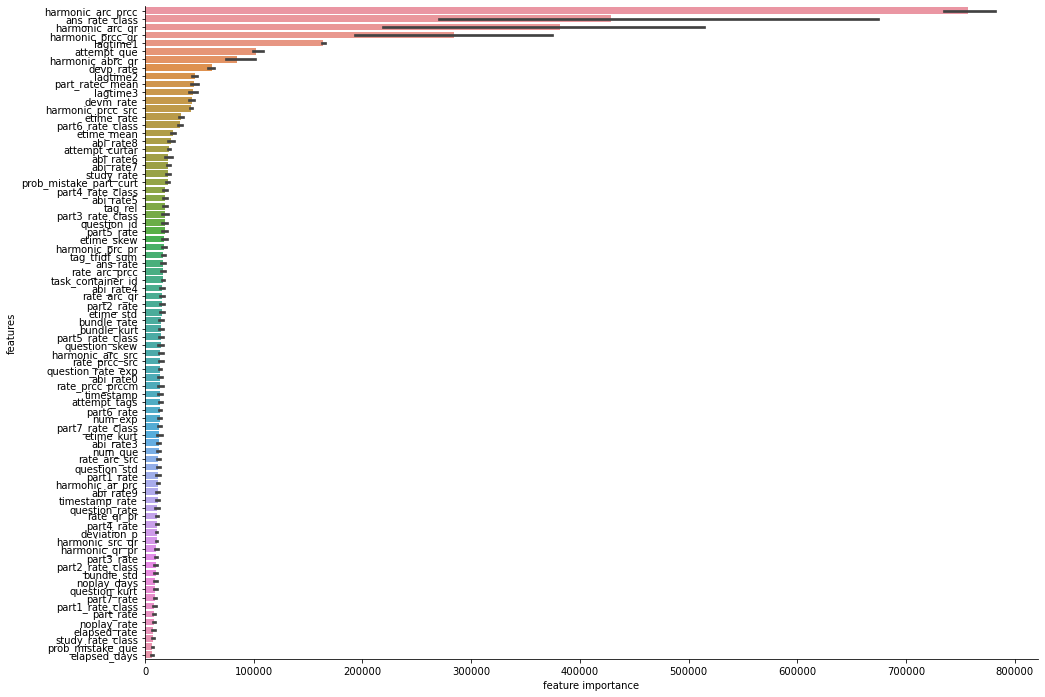

In [63]:
for lgbm in lgbms:
    _ = lgbm.plot_feature_importance()

0.789105797298675


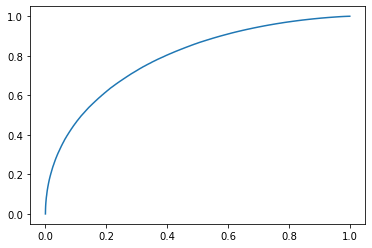

In [64]:
for lgbm in lgbms:
    score = roc_auc_score(test_data.answered_correctly, lgbm.y_pred)
    fpr, tpr, thresholds = roc_curve(test_data.answered_correctly, lgbm.y_pred)
    print(score)
    plt.plot(fpr, tpr)

In [65]:
show_cols = ["correct","answered_correctly","predict","predict_prob","user_id"]+features
test_data["predict_prob"] = lgbm.y_pred
test_data["predict"]      = test_data.predict_prob.apply(lambda x: 1 if x>0.5 else 0)
test_data["correct"]      = test_data[["answered_correctly","predict"]].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)

In [66]:
test_data.sort_values("predict_prob", ascending=False, inplace=True)
test_data[show_cols].head()

,correct,answered_correctly,predict,predict_prob,user_id,timestamp,question_id,task_container_id,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,tag_rel,tag_tfidf_sum,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_kurt,deviation_p,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
561043,1,1,1,0.999809,1579080070,1221.492065,13174,3370,0.649414,0.330811,0.028824,3767,3705,0.983398,0.848631,0.701046,0.709150,0.686567,0.526316,0.750000,0.680085,0.195489,0.291367,0.417453,0.518911,0.695946,0.807642,0.916865,1.000000,0.001262,0.021484,0.048462,0.091431,397.560211,50,0.105538,0.324261,0.013273,0,116,0.9,1.0,0.979980,1.0,1.000000,1.000000,1.000000,0.964355,1.000000,1.000000,3464,8.781250,0.980957,0.350342,-7.562500,58.125000,0.856934,1.307617,-1.684570,0.023499,0.980469,0.006352,0.003073,0.710429,3.731534,0.630859,0.115598,0.258783,0.995117,0.667474,0.990234,1.000000,0.657535,0.990138,0.768066,0.990138,0.989746,0.989889,0.979980,1.000000,1.020508,1.020429,1.019531,0.643555,1.004907
560923,1,1,1,0.999786,1579080070,1218.649780,12822,3333,0.644043,0.331543,0.024521,3647,3599,0.986816,0.847650,0.701046,0.699275,0.704545,0.526316,0.625000,0.659674,0.196970,0.293040,0.416867,0.517028,0.691686,0.805442,0.911392,1.000000,0.001313,0.006348,0.011475,0.169067,397.560211,50,0.109010,0.334151,0.013710,0,337,0.9,1.0,0.985840,1.0,1.000000,1.000000,1.000000,0.978027,0.974121,1.000000,2409,10.664062,0.986816,0.115479,8.539062,71.937500,0.986816,0.115479,71.937500,0.014458,0.986816,0.005500,0.001321,4.283027,39.258884,0.745117,0.116349,0.165995,0.992676,0.731951,0.993652,1.000000,0.793083,0.993364,0.849121,0.993364,0.992676,0.992869,0.986328,1.000000,1.014648,1.014364,1.013672,0.754883,1.007378
133423,1,1,1,0.999776,377871014,17566.363281,12515,8178,0.645996,0.264893,-0.067017,11459,10387,0.906250,0.813776,0.808939,0.768771,0.697584,0.565828,0.613808,0.676556,0.132530,0.239264,0.343091,0.431224,0.569657,0.745084,0.875485,0.970909,-0.000617,0.089844,0.167969,0.195312,12252.149414,731,1.069216,1.532975,0.063793,0,188,0.8,1.0,0.990723,1.0,1.000000,1.000000,1.000000,0.984375,1.000000,1.000000,2105,10.507812,0.991211,0.188965,10.484375,108.937500,0.865234,0.971680,-1.200195,0.010101,0.990723,0.006338,0.003030,0.027348,1.625376,0.630859,0.092538,0.143386,0.997559,0.670800,0.995605,1.000000,0.662546,0.995340,0.770996,0.980716,0.995605,0.995340,0.990723,1.000000,1.009766,1.009364,1.009766,0.636719,1.002447
481811,1,1,1,0.999746,1378999553,1314.762573,5877,4088,0.818359,0.398193,0.231934,5214,4965,0.952148,0.902622,0.881331,0.852094,0.834043,0.777693,0.847059,0.781250,0.383838,0.531250,0.614796,0.705007,0.803817,0.899281,0.951302,0.991701,-0.001256,0.006104,0.022217,0.026123,450.223236,54,0.086349,0.252160,0.010357,0,148,0.9,1.0,0.931641,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,203,4.199219,0.919922,0.375977,-2.326172,17.296875,0.919922,0.375977,17.296875,0.100037,0.927734,0.005678,0.008615,7.617540,67.900276,0.609863,0.108322,0.124325,1.000000,0.797508,0.962402,1.000000,0.683628,0.962513,0.736328,0.958652,0.964844,0.964611,0.929688,1.000000,1.073242,1.073375,1.078125,0.657227,1.000000
197179,1,1,1,0.999742,562848079,577.437195,11041,604,

In [67]:
df_res_sorted = test_data.loc[(test_data.correct==0), show_cols].sort_values("predict_prob", ascending=False)
df_res_sorted.head(20)

,correct,answered_correctly,predict,predict_prob,user_id,timestamp,question_id,task_container_id,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,tag_rel,tag_tfidf_sum,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_kurt,deviation_p,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
244322,0,0,1,0.998653,737181167,607.467407,2458,1957,0.718262,0.313965,0.040192,3200,3111,0.972168,0.805556,0.712430,0.716336,0.776667,0.686324,0.716456,0.753927,0.206897,0.336957,0.436548,0.569343,0.683862,0.793379,0.865794,0.974874,-0.001765,0.016113,0.152039,0.160095,286.666931,25,0.089583,0.189834,0.007812,0,239,0.6,0.990723,0.965820,0.980469,0.978027,0.987305,0.992676,0.977051,0.987793,0.985352,3521,7.980469,0.966797,0.285889,5.335938,36.593750,0.798340,1.081055,-0.950684,0.039520,0.966797,0.006754,0.003788,4.302670,56.205811,0.701660,0.119432,0.153718,0.983887,0.717297,0.979004,0.989011,0.708922,0.976943,0.812988,0.970819,0.978027,0.976444,0.966309,1.003462,1.025391,1.022245,1.024414,0.725586,1.003474
242477,0,0,1,0.998340,737181167,474.324554,2967,805,0.713867,0.303711,0.027069,1355,1266,0.934082,0.826087,0.700787,0.741641,0.798883,0.634146,0.714844,0.666667,0.184211,0.422222,0.402439,0.519737,0.692857,0.787500,0.864964,0.988095,-0.001531,0.024719,0.223907,0.253296,286.666931,19,0.211562,0.350055,0.014022,0,74,0.9,0.986328,0.976562,0.981934,0.983887,0.989258,0.987793,0.985840,0.984863,0.985840,2588,9.742188,0.977051,0.343506,-6.980469,49.250000,0.722656,1.000977,-1.468750,0.028427,0.976562,0.006408,0.004228,6.155283,77.952415,0.630859,0.141828,0.212609,0.985352,0.753986,0.981445,0.987060,0.704998,0.982146,0.766602,0.982295,0.981445,0.982146,0.976562,0.998517,1.009766,1.011500,1.009766,0.645996,1.002478
197226,0,0,1,0.998139,562848079,578.877075,7659,633,0.798340,0.354736,0.166016,1106,1011,0.914062,0.940000,0.818750,0.859903,0.852941,0.696970,0.712766,0.818182,0.312500,0.422222,0.581081,0.662069,0.774194,0.865672,0.937500,1.000000,-0.001493,0.061890,0.076416,1.019409,332.742920,24,0.300853,0.523397,0.021700,0,39,0.7,0.986816,0.937012,0.977539,0.980469,0.984863,0.984863,0.966309,0.982422,0.993164,1996,24.250000,0.940918,0.336182,-3.419922,21.750000,0.833008,0.767578,-0.555176,0.072571,0.938477,0.014155,0.007728,1.086081,4.093787,0.659668,0.147707,0.239345,0.980957,0.808139,0.961914,0.989980,0.730424,0.965046,0.774902,0.968262,0.961426,0.964271,0.937988,0.993609,1.052734,1.059927,1.051758,0.703125,1.012444
309402,0,0,1,0.998006,885597950,2488.048828,7792,569,0.670898,0.320068,0.028870,751,743,0.989258,0.000000,0.825397,0.777778,1.000000,0.633867,0.697842,0.670330,0.055556,0.210526,0.361111,0.504587,0.713542,0.810526,0.911765,1.000000,0.003102,0.492188,0.505127,0.515137,1767.677490,103,2.353765,3.312981,0.137150,0,31,0.8,0.987305,0.967773,0.500000,0.992188,0.989746,0.700195,0.989746,0.991211,0.993652,1235,20.062500,0.971191,0.336670,7.449219,58.093750,0.786133,1.332031,-1.593750,0.035278,0.969727,0.013759,0.008235,1.966187,10.890573,0.659668,0.159596,0.243413,0.879395,0.670614,0.978516,0.990468,0.664956,0.981544,0.785156,0.984631,0.977539,0.980542,0.968750,0.993612,1.020508,1.026741,1.018555,0.680176,1.129928
364453,0,0,1,0.997752,1057531137,1

In [68]:
for u in df_res_sorted.user_id.unique()[:3]:
    test_data.loc[test_data.user_id==u, show_cols].to_csv("debug_"+str(u)+".csv", index=False)

In [69]:
models = []
for lgbm in lgbms:
    models += lgbm.models
print(len(models))

del lgbms, train_data, tune_data
gc.collect()

4


9

# Load SAKT model

In [70]:
def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

In [71]:
class FFN(nn.Module):
    def __init__(self, state_size=200, forward_expansion=1, bn_size=(180-1), dropout=0.2):
        super(FFN, self).__init__()
        self.state_size = state_size
        
        self.lr1     = nn.Linear(state_size, forward_expansion * state_size)
        self.relu    = nn.ReLU()
        self.bn      = nn.BatchNorm1d(bn_size)
        self.lr2     = nn.Linear(forward_expansion * state_size, state_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.relu(self.lr1(x))
        x = self.bn(x)
        x = self.lr2(x)
        return self.dropout(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads=8, dropout=0.1, forward_expansion=1):
        super(TransformerBlock, self).__init__()
        self.multi_att      = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads, dropout=dropout)
        self.dropout        = nn.Dropout(dropout)
        self.layer_normal   = nn.LayerNorm(embed_dim)
        self.ffn            = FFN(embed_dim, forward_expansion=forward_expansion, dropout=dropout)
        self.layer_normal_2 = nn.LayerNorm(embed_dim)
        
    def forward(self, value, key, query, att_mask):
        att_output, att_weight = self.multi_att(value, key, query, attn_mask=att_mask)
        att_output = self.dropout(self.layer_normal(att_output + value))
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]
        x = self.ffn(att_output)
        x = self.dropout(self.layer_normal_2(x + att_output))
        return x.squeeze(-1), att_weight
    
class Encoder(nn.Module):
    def __init__(self, n_skill, max_seq=180, embed_dim=128, dropout=0.1, forward_expansion=1, num_layers=1, heads=8):
        super(Encoder, self).__init__()
        self.n_skill, self.embed_dim = n_skill, embed_dim
        self.embedding     = nn.Embedding(2 * n_skill + 1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq - 1,     embed_dim)
        self.e_embedding   = nn.Embedding(n_skill + 1,     embed_dim)
        self.layers        = nn.ModuleList([TransformerBlock(embed_dim, forward_expansion = forward_expansion) for _ in range(num_layers)])
        self.dropout       = nn.Dropout(dropout)
        
    def forward(self, x, question_ids):
        device = x.device
        x      = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        pos_x  = self.pos_embedding(pos_id)
        x      = self.dropout(x + pos_x)
        x      = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e      = self.e_embedding(question_ids)
        e      = e.permute(1, 0, 2)
        for layer in self.layers:
            att_mask      = future_mask(e.size(0)).to(device)
            x, att_weight = layer(e, x, x, att_mask=att_mask)
            x = x.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        return x, att_weight

class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=180, embed_dim=128, dropout=0.1, forward_expansion=1, enc_layers=1, heads=8):
        super(SAKTModel, self).__init__()
        self.encoder  = Encoder(n_skill, max_seq, embed_dim, dropout, forward_expansion, num_layers=enc_layers)
        self.pred     = nn.Linear(embed_dim+1, 1)
        
    def forward(self, x1, x2, question_ids):
        device = x1.device
        x, att_weight = self.encoder(x1, question_ids)
        x = torch.cat([x, x2.unsqueeze(2)], dim=2).to(device)
        x = self.pred(x)
        return x.squeeze(-1), att_weight

In [72]:
%%time
device  = torch.device("cpu")
skills  = joblib.load("/kaggle/input/riiid-sakt-model-dataset-public/skills.pkl.zip")
n_skill = len(skills)
group   = joblib.load("/kaggle/input/riiid-sakt-model-dataset-own/group.pkl.zip")
lags    = joblib.load("/kaggle/input/riiid-sakt-model-dataset-own/lags.pkl.zip")

nn_model = SAKTModel(n_skill, max_seq=180, embed_dim=128, forward_expansion=1, enc_layers=1, heads=8, dropout=0.1)
nn_model.load_state_dict(torch.load("/kaggle/input/riiid-sakt-model-dataset-own/sakt_model.pt", map_location='cpu'))

nn_model.to(device)
nn_model.eval()

CPU times: user 21.9 s, sys: 3.94 s, total: 25.9 s
Wall time: 49.3 s


SAKTModel(
  (encoder): Encoder(
    (embedding): Embedding(27047, 128)
    (pos_embedding): Embedding(179, 128)
    (e_embedding): Embedding(13524, 128)
    (layers): ModuleList(
      (0): TransformerBlock(
        (multi_att): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_normal): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN(
          (lr1): Linear(in_features=128, out_features=128, bias=True)
          (relu): ReLU()
          (bn): BatchNorm1d(179, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lr2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_normal_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (pred): Linear(in_features=129, out_featu

In [73]:
class TestDataset(Dataset):
    def __init__(self, samples, lags, test_df, max_seq=180): 
        super(TestDataset, self).__init__()
        self.samples  = samples
        self.lags     = lags
        self.user_ids = [x for x in test_df["user_id"].unique()]
        self.test_df  = test_df
        self.n_skill  = n_skill
        self.max_seq  = max_seq
    
    def __len__(self):
        return self.test_df.shape[0]
    
    def __getitem__(self, index):
        test_info = self.test_df.iloc[index]

        user_id      = test_info["user_id"]
        target_id    = test_info["question_id"]
        lagtime_mean = test_info["lagtime_mean"]

        q  = np.zeros(self.max_seq, dtype=int)
        qa = np.zeros(self.max_seq, dtype=int)
        l  = np.zeros(self.max_seq, dtype=float)

        if user_id in self.samples.index:
            q_, qa_ = self.samples[user_id]
            l_      = self.lags[user_id]
            seq_len = len(q_)
            if seq_len >= self.max_seq:
                q  = q_ [-self.max_seq:]
                qa = qa_[-self.max_seq:]
                l  = l_ [-self.max_seq:]
            else:
                q [-seq_len:] = q_
                qa[-seq_len:] = qa_
                l [-seq_len:] = l_
        
        x1  = q[1:].copy()
        x1 += (qa[1:] == 1) * self.n_skill
        x2  = l[1:].copy()
        questions = np.append(q[2:], [target_id])
        
        return x1, x2, questions

# Prediction

In [74]:
def insert_new_data_to_hist(ary, ins):
    ary = ary.copy()
    ary = np.vstack([ary, ins])
    ary = ary[np.argsort(ary[:,0])]  # Sort by user_id
    return ary

def groupby_with_numpy(ary, t_idxs, qucnt):
    ary = ary.copy()
    g   = sum([[i+1 for _ in range(c)] for i, c in enumerate(qucnt)], [])
    r   = np.zeros((qucnt.shape[0], t_idxs.shape[0]))
    for i, t in enumerate(t_idxs):
        r[:,i] = np.bincount(g, ary[:,t])[1:]
    return r

def add_mistake_feat(df, t_col, n_col):
    df = df.copy()
    if df[n_col].min() == 0:
        df[t_col] = df[n_col].apply(lambda x: 0.6*x**(-0.2) if x!=0 else 0.6)
    else:
        df[t_col] = 0.6*df[n_col]**(-0.2)
    return df

def get_num_etimes(df):
    num_etimes = []
    for u, et in np.array(df[["user_id","prior_question_elapsed_time"]]):
        if u in d.keys():
            etime_mean = d_etime[d[u][-1, 1]]
            et_norm    = et / (1000*3600)
            num_etimes.append(et_norm - etime_mean)
        else:
            num_etimes.append(0)
    return num_etimes

def add_to_timedict(df):
    for u, t in np.array(df[["user_id","timestamp"]]):
        if u in d_timestamp.keys():
            d_timestamp[u] = np.unique(np.hstack([d_timestamp[u], np.array([t])]))
        else:
            d_timestamp[u] = np.array([t])

def add_to_history(df, new_row_id):
    for r in np.array(df[["user_id","question_id","part","tag1"]]):
        if r[0] in d.keys():
            d[r[0]] = np.vstack([d[r[0]], np.hstack([np.array(new_row_id), r[1:], np.array(0)])])
        else:
            d[r[0]] = np.array([np.hstack([np.array(new_row_id), r[1:], np.array(0)])])
            
def upd_history_ans(df):
    for r in np.array(df[["user_id","answered_correctly"]]):
        if r[0] in d.keys() and r[1] == 1:
            d[r[0]][-1,-1] = r[1]

In [75]:
df_lecs.drop(["part","starter"], axis=1, inplace=True)
df_qs = df_qs.merge(df_question_rate, on=["question_id","bundle_id"]).merge(df_part_rate, on="part").merge(df_etime_rate, on="question_id")
df_qs.sort_values("question_id", inplace=True)
df_qs.reset_index(drop=True, inplace=True)
df_qs["LorR"] = 0
df_qs.loc[df_qs.part.isin([5,6,7]), "LorR"] = 1

print(df_lecs.shape, df_qs.shape)
display(df_lecs.head(2))
display(df_qs.head(2))

(418, 4) (27046, 32)


,question_id,concept,intention,solving_question
0,89,1,0,0
1,100,1,0,0


,question_id,bundle_id,part,tag_rel,tag_tfidf_sum,num_tag,tag1,tag2,tag3,tag4,tag5,tag6,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_skew,bundle_kurt,deviation_p,deviation_m,question_rate_class,prior_question_had_explanation,question_rate_exp,question_rate_class_exp,part_rate,etime_mean,etime_std,etime_skew,etime_kurt,LorR
0,0,0,1,3891,12.773438,4,51,131,162,38,0,0,0.907715,0.510742,3.820312,14.742188,0.907715,0.510742,3.820312,14.742188,0.123718,1.216797,9,0,0.830566,8,0.745117,0.005476,0.002338,18.473738,556.210571,0
1,0,0,1,3891,12.773438,4,51,131,162,38,0,0,0.907715,0.510742,3.820312,14.742188,0.907715,0.510742,3.820312,14.742188,0.123718,1.216797,9,1,0.912109,9,0.745117,0.005476,0.002338,18.473738,556.210571,0


In [76]:
sort_cols    = ['user_id',"num_exp",'num_ans','num_devp','num_devm',"num_etime",'num_que'] + part_cols + abi_cols
ar_hist      = np.array(df_history[sort_cols])
ar_qs        = np.array(df_qs)[:,0]
ar_ans_class = np.array(df_ans_class)[:,1]

In [77]:
iter_test = env.iter_test()

In [78]:
#(test_df, sample_prediction_df) = next(iter_test)
#test_df_bk = test_df.copy()
#idx = 0

In [79]:
t_cols  = ["ans_rate_class","study_rate_class"] + [f"part{p}_rate_class" for p in range(1,8)]
n_cols  = ["num_que",       "num_que"]          + num_part_cols
r_cols  = ['row_id','timestamp','user_id','question_id','content_type_id','task_container_id','prior_question_elapsed_time','prior_question_had_explanation']
df_test = pd.DataFrame()

In [80]:
%%time
for idx, (test_df, sample_prediction_df) in enumerate(iter_test):
    # Modify DataFrame
    test_df.prior_question_had_explanation = (test_df.prior_question_had_explanation.fillna(False) * 1).astype(int)
    test_df.prior_question_elapsed_time    = test_df.prior_question_elapsed_time.fillna(0).astype(int)
    
    # Get prior correct answer
    prior_ans = eval(test_df.prior_group_answers_correct.values[0])

    # DataFrame to array
    test_ary = np.array(test_df)[:,:8]
    lec_ary  = test_ary[test_ary[:,4]==1, 2:4]
    test_ary = test_ary[test_ary[:,4]==0, :]

    # Make user information
    qusers, qucnt = np.unique(np.sort(test_ary[:,2]), return_counts=True)
    qusers        = qusers.astype("int32")
    existing_qusers_bol = np.isin(ar_hist[:,0], qusers)
    not_existing_qusers = qusers[~np.isin(qusers, ar_hist[existing_qusers_bol, 0])]

    # Store some information
    questions = np.unique(test_ary[:,3].astype("int32"))
    group_num = test_df.index[:test_ary.shape[0]]
    
    # Add the number of correct answering to history
    if len(prior_ans) != 0 and prior_ans is not None and prior_ans is not np.nan:
        # Delete lecture data
        prior_ans = np.array([a for a in prior_ans if a != -1])
        if 0 < len(prior_ans) and len(prior_ans) == len(prior_test_user_ids) == len(prior_test_devp):
            df_prev['answered_correctly'] = prior_ans
            upd_history_ans(df_prev)
            # Update for SAKT model
            if ENSEMBLE:
                prev_group = df_prev.groupby('user_id').apply(lambda x: (x['question_id'].values,
                                                                         x['answered_correctly'].values,
                                                                         x["lagtime_mean"].values))
                for prev_user_id in prev_group.index:
                    if prev_user_id in group.index:
                        group[prev_user_id] = (np.append(group[prev_user_id][0], prev_group[prev_user_id][0])[-180:], 
                                               np.append(group[prev_user_id][1], prev_group[prev_user_id][1])[-180:])
                        lags [prev_user_id] = (np.append(lags [prev_user_id],    prev_group[prev_user_id][2])[-180:])

                    else:
                        group[prev_user_id] = (prev_group[prev_user_id][0], prev_group[prev_user_id][1])
                        lags [prev_user_id] = prev_group[prev_user_id][2]
            # Update for LGBM
            ans_ary = np.array([prior_test_user_ids,
                                prior_ans,
                                prior_test_devp.fillna(9),
                                prior_test_devm,
                                prior_test_etime]).T
            ans_ary = ans_ary[ans_ary[:,2]!=9]
            if 0 < ans_ary.shape[0]:
                # The data answered correctly should be aggregated
                ans_ary[:,2] *= ans_ary[:,1]
                ans_ary[:,3]  = ans_ary[:,2] + np.where(ans_ary[:,1]==0, -1, 0) * ans_ary[:,3]
                # Calculate ans and num for each part and user ability
                part_ans_ary  = prior_test_part * ans_ary[:,1].reshape(-1,1)
                abi_ans_ary   = prior_test_qc   * ans_ary[:,1].reshape(-1,1)
                ans_ary = np.hstack([ans_ary,
                                     np.ones(ans_ary.shape[0]).reshape(-1,1),
                                     part_ans_ary,
                                     prior_test_part,
                                     abi_ans_ary,
                                     prior_test_qc])
                ans_ary = ans_ary[np.argsort(ans_ary[:,0])]
                if len(prior_test_user_ids) != len(np.unique(prior_test_user_ids)):
                    # Group by user_id because of existing some questions in the user
                    _, qacnt = np.unique(ans_ary[:,0], return_counts=True)
                    ans_ary  = groupby_with_numpy(ans_ary, np.arange(1, ans_ary.shape[1]), qacnt)
                else:
                    ans_ary  = ans_ary[:,1:]
                # Update existing data
                ar_hist[prior_hist_equb, 2:] += ans_ary
    
    # Add new users to history
    if 0 < not_existing_qusers.shape[0]:
        ins_exp = np.hstack([not_existing_qusers.reshape(-1,1),
                             np.zeros((not_existing_qusers.shape[0], ar_hist.shape[1]-1))])
        ar_hist = insert_new_data_to_hist(ar_hist, ins_exp)
        existing_qusers_bol = np.isin(ar_hist[:,0], qusers)
    # Update existing data
    if 0 < test_ary.shape[0]:
        ary = test_ary[:,[2,7]].copy()
        ary = ary.astype(int)
        ary = ary[np.argsort(ary[:,0])]
        ar_hist[existing_qusers_bol, 1] += groupby_with_numpy(ary, np.array([1]), qucnt).flatten()

    # ========================================
    # Prediction with LGBM
    # Merge with some DataFrames
    df_hist = pd.DataFrame(ar_hist[existing_qusers_bol], columns=sort_cols)
    df_test = pd.DataFrame(test_ary, columns=r_cols)
    df_test = df_test.merge(df_hist, on="user_id", sort=False)
    df_test = df_test.merge(df_qs[np.isin(ar_qs, questions)], on=["question_id","prior_question_had_explanation"], sort=False)
    
    # Make features
    df_test["ans_rate"]   = (df_test.num_ans   / df_test.num_que).fillna(0)
    df_test["devp_rate"]  =  df_test.num_devp  / df_test.num_que
    df_test["devm_rate"]  =  df_test.num_devm  / df_test.num_que
    df_test["etime_rate"] =  df_test.num_etime / df_test.num_que
    ar_study_rate = np.array(df_test.num_exp / df_test.num_que)
    ar_study_rate[np.isnan(ar_study_rate)] = 0
    ar_study_rate[np.isinf(ar_study_rate)] = 0
    ar_study_rate[1 < ar_study_rate]       = 1
    df_test["study_rate"] = ar_study_rate
    df_class = df_ans_class[np.isin(ar_ans_class, questions)].copy()
    df_test  = cut_and_merge_with_class(df_test, df_class, "ans_rate",   "ans_rate_class")
    df_test  = cut_and_merge_with_class(df_test, df_class, "study_rate", "study_rate_class")
    df_test  = add_mistake_feat(df_test, "prob_mistake_que", "num_que")
    for p in range(0,10):
        if p in [0,3,4,5,6,7,8,9]:
            df_test[f"abi_rate{p}"]  = (df_test[f"ans_abi{p}"]  / df_test[f"num_abi{p}"]).fillna(0)
        if p in [1,2,3,4,5,6,7]:
            df_test[f"part{p}_rate"] = (df_test[f"ans_part{p}"] / df_test[f"num_part{p}"]).fillna(0)
            df_test = add_mistake_feat(df_test, f"prob_mistake_part{p}", f"num_part{p}")
            df_test = cut_and_merge_with_class(df_test, df_class, f"part{p}_rate", f"part{p}_rate_class")
    for t, n in zip(t_cols, n_cols):
        if df_test[n].min() < 5:
            # Replace to 0.3/0.5/0.7 for small answering
            df_test = change_rate_with_num(df_test, t, n, method="respectively")
            df_test = change_rate_with_num(df_test, t, n, method="bundle")
    df_test["lagtime1"]       = (df_test[["user_id","timestamp"]].apply(lambda x: get_lagtime(x[0], x[1], -1), axis=1) / (1000*3600)).astype("float32")
    df_test["lagtime2"]       = (df_test[["user_id","timestamp"]].apply(lambda x: get_lagtime(x[0], x[1], -2), axis=1) / (1000*3600)).astype("float32")
    df_test["lagtime3"]       = (df_test[["user_id","timestamp"]].apply(lambda x: get_lagtime(x[0], x[1], -3), axis=1) / (1000*3600)).astype("float32")
    df_test["lagtime_mean"]   = (df_test.lagtime1 + df_test.lagtime2 + df_test.lagtime3) / 3
    df_test["timestamp"]      = (df_test.timestamp / (1000*3600)).astype("float32")
    df_test["lagtime1"]       = (df_test.timestamp - df_test.lagtime1).astype("float32")
    df_test["lagtime2"]       = (df_test.timestamp - df_test.lagtime2).astype("float32")
    df_test["lagtime3"]       = (df_test.timestamp - df_test.lagtime3).astype("float32")
    df_test["lagtime_mean"]   = np.log((df_test.timestamp - df_test.lagtime_mean) + 1).astype("float32")
    df_test["noplay_days"]    = (df_test[["user_id","timestamp"]].apply(lambda x: get_noplay_days(x[0], x[1]), axis=1)).astype("float32")
    df_test["elapsed_days"]   = (df_test.timestamp / 24).astype("int32")
    df_test["noplay_rate"]    = (df_test.noplay_days  / df_test.num_que).astype("float32")
    df_test["timestamp_rate"] = (df_test.timestamp    / df_test.num_que).astype("float32")
    df_test["elapsed_rate"]   = (df_test.elapsed_days / df_test.num_que).astype("float32")
    df_test["attempt_que"]    = df_test[["user_id","question_id"]].apply(lambda x: get_attempt_que(x[0], 101230332+idx, x[1]), axis=1)
    df_test["attempt_tags"]   = df_test[["user_id","tag1"]].apply(lambda x: get_attempt_tags(x[0], 101230332+idx, x[1]), axis=1)
    df_test["attempt_curtar"] = df_test[["user_id"]].apply(lambda x: get_attempt_curt_ans_rate(x[0], 101230332+idx), axis=1)
    all_prob_mistake = np.array(df_test[part_mistake_cols])
    all_part_rate    = np.array(df_test[["part1_rate","part2_rate","part3_rate","part4_rate","part5_rate","part6_rate","part7_rate"]])
    all_part_ratec   = np.array(df_test[["part1_rate_class","part2_rate_class","part3_rate_class","part4_rate_class","part5_rate_class","part6_rate_class","part7_rate_class"]])
    all_abi_rate     = np.array(df_test[["abi_rate0","abi_rate3","abi_rate4","abi_rate5","abi_rate6","abi_rate7","abi_rate8","abi_rate9"]])
    one_hot_part     = np.identity(8) [df_test.part][:,1:]
    one_hot_ability  = np.identity(10)[df_test.question_rate_class_exp][:,[0,3,4,5,6,7,8,9]]
    df_test["prob_mistake_part_curt"] = np.nanmax(one_hot_part*all_prob_mistake, axis=1)
    df_test["part_rate_curt"]         = np.nanmax(one_hot_part*all_part_rate,    axis=1)
    df_test["part_ratec_curt"]        = np.nanmax(one_hot_part*all_part_ratec,   axis=1)
    df_test["abi_rate_curt"]          = np.nanmax(one_hot_ability*all_abi_rate,  axis=1)
    df_test["part_ratec_mean"]        = np.nan_to_num(all_part_ratec).sum(1) / 7
    df_test["harmonic_ar_prc"]        = 2 * (df_test.ans_rate         * df_test.part_rate_curt)    / (df_test.ans_rate         + df_test.part_rate_curt)
    df_test["harmonic_arc_qr"]        = 2 * (df_test.ans_rate_class   * df_test.question_rate_exp) / (df_test.ans_rate_class   + df_test.question_rate_exp)
    df_test["harmonic_arc_prcc"]      = 2 * (df_test.ans_rate_class   * df_test.part_ratec_curt)   / (df_test.ans_rate_class   + df_test.part_ratec_curt)
    df_test["harmonic_prc_pr"]        = 2 * (df_test.part_rate_curt   * df_test.part_rate)         / (df_test.part_rate_curt   + df_test.part_rate)
    df_test["harmonic_prcc_qr"]       = 2 * (df_test.part_ratec_curt  * df_test.question_rate_exp) / (df_test.part_ratec_curt  + df_test.question_rate_exp)
    df_test["harmonic_qr_pr"]         = 2 * (df_test.part_rate        * df_test.question_rate_exp) / (df_test.part_rate        + df_test.question_rate_exp)
    df_test["harmonic_abrc_qr"]       = 2 * (df_test.abi_rate_curt    * df_test.question_rate_exp) / (df_test.abi_rate_curt    + df_test.question_rate_exp)
    df_test["harmonic_arc_src"]       = 2 * (df_test.ans_rate_class   * df_test.study_rate_class)  / (df_test.ans_rate_class   + df_test.study_rate_class)
    df_test["harmonic_prcc_src"]      = 2 * (df_test.part_ratec_curt  * df_test.study_rate_class)  / (df_test.part_ratec_curt  + df_test.study_rate_class)
    df_test["harmonic_src_qr"]        = 2 * (df_test.study_rate_class * df_test.question_rate_exp) / (df_test.study_rate_class + df_test.question_rate_exp)
    df_test["rate_arc_prcc"]          = df_test.ans_rate_class  / df_test.part_ratec_curt
    df_test["rate_arc_src"]           = df_test.ans_rate_class  / df_test.study_rate_class
    df_test["rate_prcc_src"]          = df_test.part_ratec_curt / df_test.study_rate_class
    df_test["rate_arc_qr"]            = df_test.ans_rate_class  / df_test.question_rate_exp
    df_test["rate_qr_pr"]             = df_test.part_rate       / df_test.question_rate_exp
    df_test["rate_prcc_prccm"]        = df_test.part_ratec_curt / df_test.part_ratec_mean

    # Store prior infomation for next batch
    prior_hist_equb     = existing_qusers_bol
    prior_test_user_ids = np.array(df_test.user_id).astype("int32")
    prior_test_part     = one_hot_part
    prior_test_qc       = one_hot_ability
    prior_test_devp     = df_test.deviation_p
    prior_test_devm     = df_test.deviation_m
    prior_test_etime    = get_num_etimes(df_test)

    # Fill Nan by 0
    df_test.fillna(0, inplace=True)
    
    # Sort to default order
    df_test.sort_values("row_id",  inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    if idx < 1:
        display(test_df)
        display(df_test[features+categoricals])

    # Prediction
    reults = np.zeros(df_test.shape[0])
    for model in models:
        reults += model.predict(df_test[features+categoricals], num_iteration=model.best_iteration) / len(models)
        
    # ========================================
    # Prediction with SAKT model
    if ENSEMBLE:
        outs = []
        test_dataset    = TestDataset(group, lags, df_test[["user_id","question_id","lagtime_mean"]])
        test_dataloader = DataLoader(test_dataset, batch_size=df_test.shape[0], shuffle=False)
        for item in test_dataloader:
            x1 = item[0].to(device).long()
            x2 = item[1].to(device).float()
            target_id = item[2].to(device).long()
            with torch.no_grad():
                output, att_weight = nn_model(x1, x2, target_id)
            outs.extend(torch.sigmoid(output)[:, -1].view(-1).data.cpu().numpy())
            
    # ========================================
    # Submit and post processing for the next batch
    if ENSEMBLE:
        df_test['answered_correctly'] = S * np.array(outs) + L * reults
    else:
        df_test['answered_correctly'] = reults

    # Add current timestamp to time dict
    add_to_timedict(test_df)
    # Add current data to history
    add_to_history(df_test, 101230332+idx)
    # Store for updating knowledges for SAKT model
    df_prev = df_test[['user_id','question_id',"lagtime_mean"]].copy()
        
    # Submit to predict function
    df_test = df_test[['row_id', 'answered_correctly']].copy()
    df_test.index = group_num
    env.predict(df_test)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
group_num,,,,,,,,,,
0,0,0,275030867,5729,0,0,0,0,[],[]
0,1,13309898705,554169193,12010,0,4427,19000,1,NaN,NaN
0,2,4213672059,1720860329,457,0,240,17000,1,NaN,NaN
0,3,62798072960,288641214,13262,0,266,23000,1,NaN,NaN
0,4,10585422061,1728340777,6119,0,162,72400,1,NaN,NaN
0,5,18020362258,1364159702,12023,0,4424,18000,1,NaN,NaN
0,6,2325432079,1521618396,574,0,1367,18000,1,NaN,NaN
0,7,39456940781,1317245193,12043,0,5314,17000,1,NaN,NaN
0,8,3460555189,1700555100,7910,0,532,21000,1,NaN,NaN


,timestamp,question_id,task_container_id,ans_rate,devp_rate,devm_rate,num_que,num_exp,study_rate,part1_rate,part2_rate,part3_rate,part4_rate,part5_rate,part6_rate,part7_rate,abi_rate0,abi_rate3,abi_rate4,abi_rate5,abi_rate6,abi_rate7,abi_rate8,abi_rate9,etime_rate,lagtime1,lagtime2,lagtime3,noplay_days,elapsed_days,noplay_rate,timestamp_rate,elapsed_rate,attempt_que,attempt_tags,attempt_curtar,ans_rate_class,study_rate_class,part1_rate_class,part2_rate_class,part3_rate_class,part4_rate_class,part5_rate_class,part6_rate_class,part7_rate_class,tag_rel,tag_tfidf_sum,question_rate,question_std,question_skew,question_kurt,bundle_rate,bundle_std,bundle_kurt,deviation_p,question_rate_exp,etime_mean,etime_std,etime_skew,etime_kurt,part_rate,prob_mistake_que,prob_mistake_part_curt,part_ratec_mean,harmonic_ar_prc,harmonic_arc_qr,harmonic_arc_prcc,harmonic_prc_pr,harmonic_prcc_qr,harmonic_qr_pr,harmonic_abrc_qr,harmonic_arc_src,harmonic_prcc_src,harmonic_src_qr,rate_arc_prcc,rate_arc_src,rate_prcc_src,rate_arc_qr,rate_qr_pr,rate_prcc_prccm
0,0.000000,5729,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,751,2.890625,0.559082,0.842773,-0.902344,0.551758,0.559082,0.842773,0.551758,0.688477,0.419434,0.005904,0.005771,6.429668,68.769867,0.609863,0.600000,0.600000,0.500000,0.000000,0.456299,0.500000,0.000000,0.456187,0.497070,0.000000,0.500000,0.500000,0.456299,1.000000,1.000000,1.000000,1.192383,1.454102,1.000000
1,3697.194092,12010,4427,0.709175,0.411233,0.166186,5199.0,5129.0,0.986536,0.739726,0.789837,0.719888,0.689300,0.645957,0.736000,0.000000,0.444444,0.502970,0.562416,0.652762,0.711898,0.841478,0.925439,0.980843,-0.001353,0.051270,0.059814,0.068359,1437.388184,154,0.276474,0.711136,0.029621,1,183,0.5,0.927734,0.834961,0.841309,0.865234,0.906250,0.822754,0.864258,0.904785,0.500000,4393,12.203125,0.830078,0.991211,2.132812,2.734375,0.830078,0.991211,2.734375,0.282227,0.830078,0.004932,0.002493,23.128811,677.006592,0.708496,0.108385,0.137295,0.815430,0.747336,0.875977,0.895395,0.746959,0.847292,0.764160,0.875168,0.878906,0.849828,0.832031,1.072235,1.111328,1.036257,1.117188,0.853516,1.061078
2,1170.464478,457,240,0.541502,0.203310,-0.332016,253.0,243.0,0.960474,0.000000,0.544944,0.555556,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.400000,0.564103,0.520000,0.602410,0.666667,0.001191,0.083130,0.098267,68.258911,1092.179810,48,4.316916,4.626342,0.189723,0,63,0.6,0.760742,0.847168,0.500000,0.649902,0.795898,0.500000,0.738770,0.500000,0.500000,4717,12.578125,0.838867,0.502441,1.379883,7.644531,0.838867,0.502441,7.644531,0.215454,0.840332,0.004462,0.002774,19.596954,488.206085,0.708496,0.198393,0.212847,0.597656,0.543217,0.798340,0.700968,0.616050,0.732950,0.768555,0.701753,0.801758,0.735539,0.843750,1.170548,0.897949,0.767147,0.905273,0.843262,1.087418
3,17443.908203,13262,266,0.684982,0.307234,0.006711,273.0,243.0,0.890110,0.750000,0.671642,0.333333,0.444444,0.725275,0.500000,0.000000,0.285714,0.500000,0.416667,0.454545,0.602740,0.818182,0.886792,1.000000,-0.000694,20.068359,20.078125,20.091797,17348.986328,726,63.549400,63.897099,2.659341,0,7,0.7,0.833984,0.759766,0.700195,0.787598,0.500000,0.653809,0.960449,0.500000,0.300049,378,3.578125,0.824219,0.802246,-2.089844,2.945312,0.824219,0.802246,2.945312,0.269775,0.824219,0.006563,0.005092,4.787202,44.437027,0.609863,0.195397,0.211903,0.628906,0.704553,0.829102,0.892760,0.662581,0.887134,0.701172,0.854361,0.795410,0.848401,0.790527,0.868327,1.097656,1.264139,1.011719,0.739746,1.527174
4,2940.395020,6119,162,0.572438,0.303887,-0.038814,283.0,267.0,0.943463,0.000000,0.000000,0.000000,0.662338,0.452830,0.656250,0.617647,0.304348,0.258065,0.431818,0.477273,0.540541,0.759259,0.902439,1.00

CPU times: user 3.49 s, sys: 468 ms, total: 3.96 s
Wall time: 2.81 s
